## Setup, Loading Data and CDFs

In [7]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'cwt-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [8]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_cwt_1e5rawcomp_ravdess.ipynb


In [9]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawcomp\\cwt\\statement_2'

In [10]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [11]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [12]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()

In [13]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


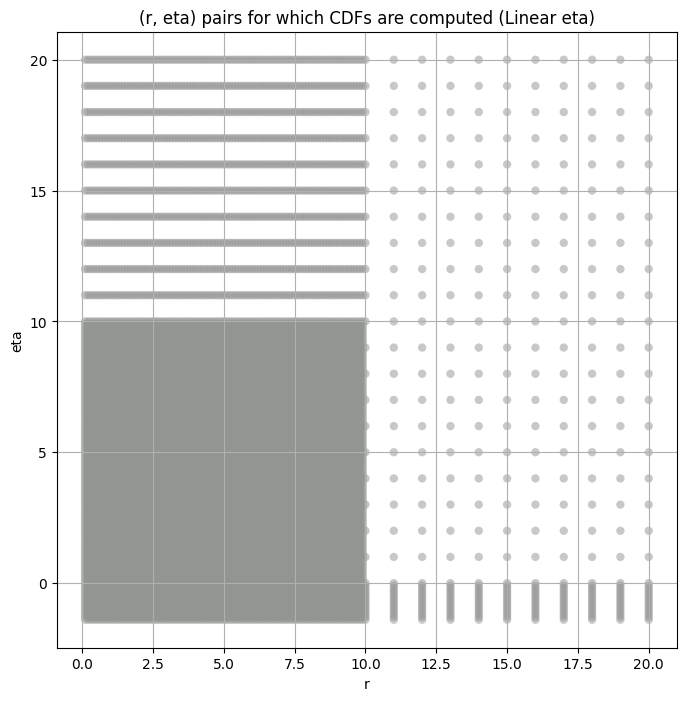

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [14]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [15]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [16]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304364e+08  8.450577e+08  1.021506e+09  11.473453    9.685472   
5     2.321099e+09  2.173827e+09  2.472827e+09   4.321749    3.780649   
8     1.711880e+09  1.608208e+09  1.819152e+09   3.817738    3.300339   
11    1.487492e+09  1.403327e+09  1.572967e+09   2.947570    2.643493   
14    3.505658e+08  3.214803e+08  3.808777e+08   8.853598    7.760434   
18    7.140621e+07  6.547071e+07  7.783148e+07   9.277631    7.097496   
21    2.798554e+07  2.521406e+07  3.104261e+07  14.152540   10.132266   
24    2.339963e+07  2.047373e+07  2.657507e+07  23.594416   19.813868   
27    1.142615e+07  9.846249e+06  1.313120e+07  29.143429   24.490961   
31    3.075916e+05  2.548352e+05  3.733561e+05  52.778656   33.753050   

      kurt_upper  total_samples  
band                             
2      14.096589       100000.0  
5       4.902878       100000.0  
8       4.358519       100000.0  
11      3.266759       100000.0  
14     10.020346       100000.0  
18     12.407567       100000.0  
21     20.440014       100000.0  
24     27.847523       100000.0  
27     34.455246       100000.0  
31    124.280266       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [17]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [18]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     9.304364e+08   9.304364e+08    9.017899e+08    8.818815e+08   
5     2.321099e+09   2.321099e+09    2.285513e+09    2.255954e+09   
8     1.711880e+09   1.711880e+09    1.686695e+09    1.665008e+09   
11    1.487492e+09   1.487492e+09    1.472723e+09    1.459527e+09   
14    3.505658e+08   3.505658e+08    3.424192e+08    3.356475e+08   
18    7.140621e+07   7.140621e+07    6.899667e+07    6.734786e+07   
21    2.798554e+07   2.798554e+07    2.668824e+07    2.585708e+07   
24    2.339963e+07   2.339963e+07    2.227091e+07    2.140320e+07   
27    1.142615e+07   1.142615e+07    1.080954e+07    1.033382e+07   
31    3.075916e+05   3.075916e+05    2.790813e+05    2.622133e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       8.643990e+08     8.484055e+08     8.195040e+08     7.935292e+08   
5       2.229221e+09     2.204410e+09     2.158984e+09     2.117641e+09   
8       1.645342e+09     1.627257e+09     1.594639e+09     1.565419e+09   
11      1.447145e+09     1.435361e+09     1.413169e+09     1.392399e+09   
14      3.295742e+08     3.239940e+08     3.139144e+08     3.048950e+08   
18      6.596730e+07     6.475625e+07     6.266922e+07     6.088491e+07   
21      2.518117e+07     2.459995e+07     2.362236e+07     2.280883e+07   
24      2.065369e+07     1.998403e+07     1.881427e+07     1.780817e+07   
27      9.923404e+06     9.557462e+06     8.919998e+06     8.373733e+06   
31      2.484189e+05     2.365429e+05     2.166872e+05     2.003978e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        7.697768e+08     7.478240e+08     7.273622e+08     6.730136e+08  
5        2.079358e+09     2.043542e+09     2.009768e+09     1.917973e+09  
8        1.538694e+09     1.513925e+09     1.490690e+09     1.427843e+09  
11       1.372763e+09     1.354070e+09     1.336188e+09     1.286456e+09  
14       2.966654e+08     2.890671e+08     2.819929e+08     2.631744e+08  
18       5.931058e+07     5.789344e+07     5.660040e+07     5.326944e+07  
21       2.210632e+07     2.148502e+07     2.092552e+07     1.949895e+07  
24       1.692208e+07     1.612931e+07     1.541225e+07     1.360280e+07  
27       7.894340e+06     7.466906e+06     7.081519e+06     6.114641e+06  
31       1.865635e+05     1.745680e+05     1.640098e+05     1.385309e+05

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02359410158938202 930436350.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.023982735266035116 901789900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.024698474055961803 881881540.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.025343993408652454 864399000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.02594975930384394 848405500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.026538090286546967 819504000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.02587058636449502 793529200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.026538090286546967 769776830.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.026538090286546967 747824000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.026538090286546967 727362200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.026538090286546967 673013600.0
Number of samples: 100000, Without approximation : 100000.0


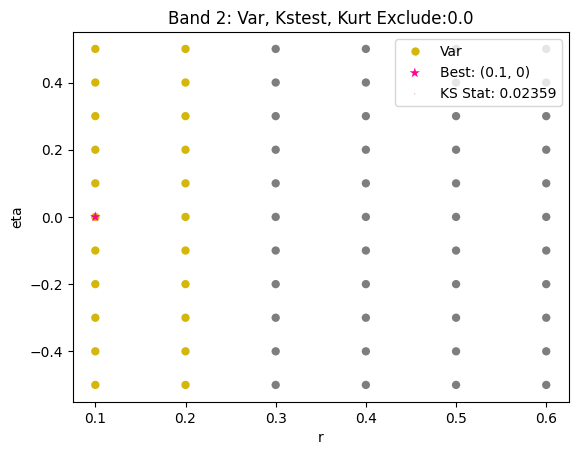

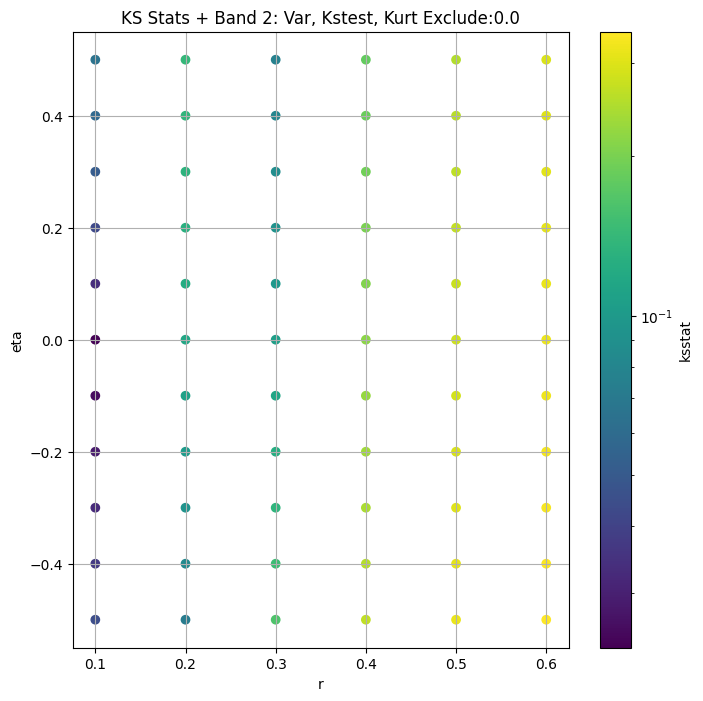

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.032837777871725815 2321099000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03237183651222991 2285513000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03248256142450842 2255954000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03321224274811989 2229220900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.033898044610861544 2204409600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03517692939016488 2158983700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0345990827477245 2117640700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03433626636677338 2079357800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03539879969309774 2043541800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03641731560696149 2009768000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.036578764380199816 1917973400.0
Number of samples: 100000, Without approximation : 100000.0


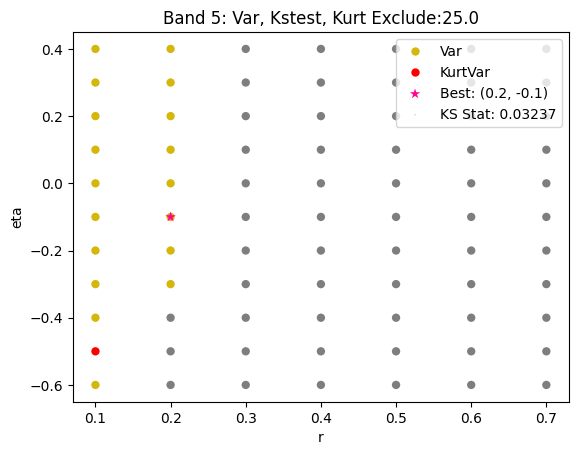

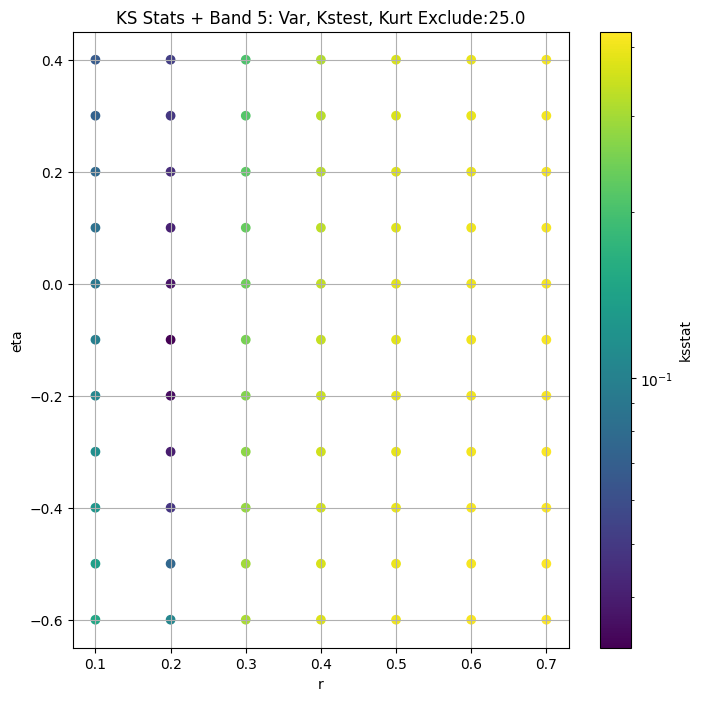

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.024266090155630998 1711880300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.025332383158265276 1686694900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.025067742561571127 1665008400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.02471521585991243 1645341700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.025455790777975718 1627256800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.026171945359224402 1594639100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.026071640303250293 1565418900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.027307147623929884 1538694000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.026813256931463803 1513925000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.027639694393100253 1490690300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.02898376864595109 1427842600.0
Number of samples: 100000, Without approximation : 100000.0


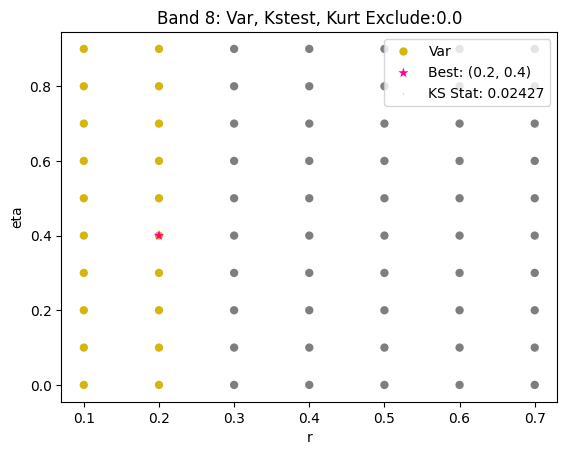

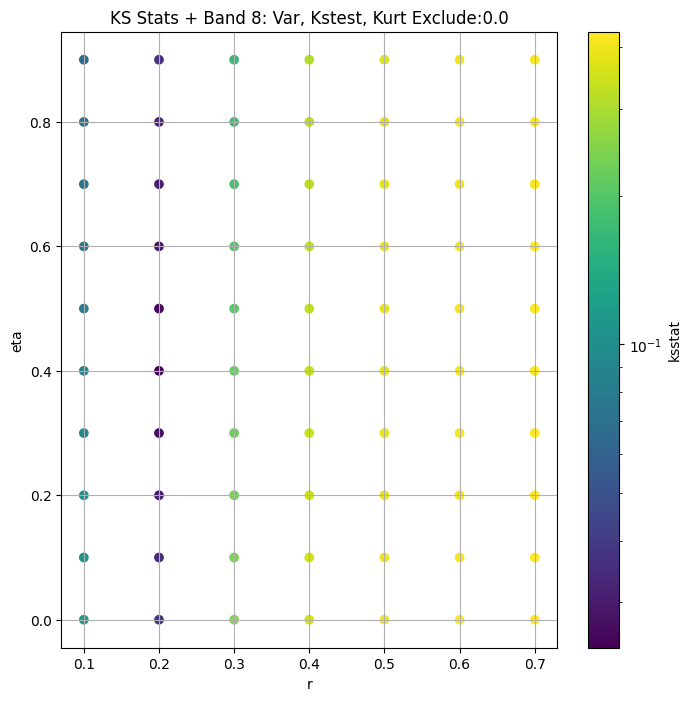

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.03172365640683655 1487492100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.03133866610244168 1472722700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.030990233170192116 1459527200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.031275022910493055 1447144700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.03177249713304782 1435361200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.03271799851824768 1413168500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.03352920418365263 1392399200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.03297653594470512 1372763100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.03302157708991864 1354069500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.033826089773305285 1336188000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.034393942059205984 1286456400.0
Number of samples: 100000, Without approximation : 100000.0


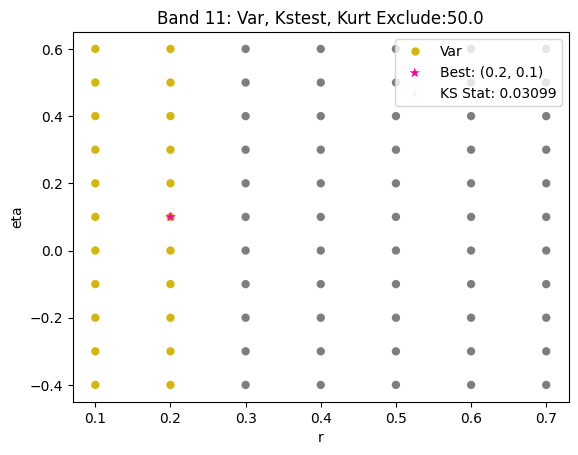

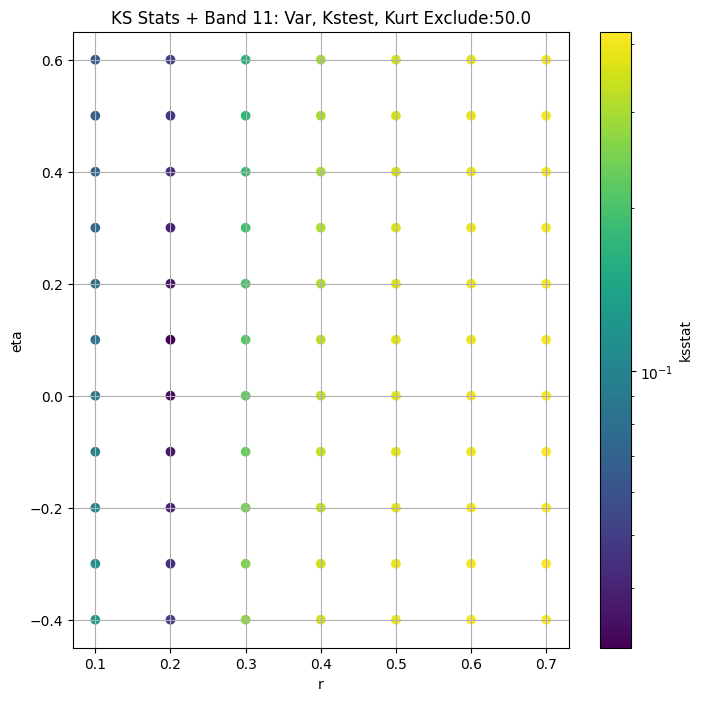

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.018340470281598464 350565760.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.017476101350395193 342419230.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.01849823671820175 335647500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.019432278382759835 329574240.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02032246563069373 323994020.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.021972212457456397 313914430.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.022370936975770583 304894980.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.021280972846955182 296665400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.021964083629278666 289067070.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.023230632260218112 281992860.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.024761017219677273 263174420.0
Number of samples: 100000, Without approximation : 100000.0


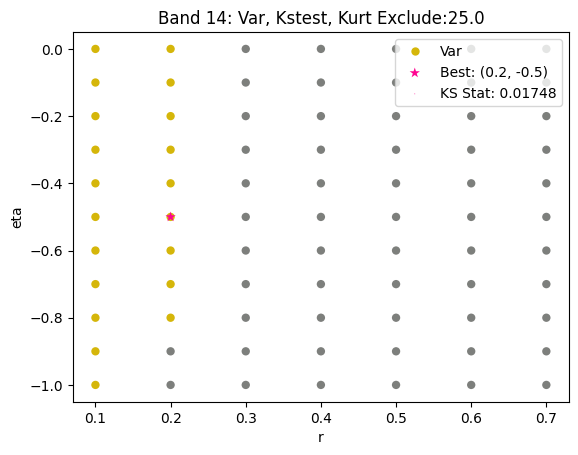

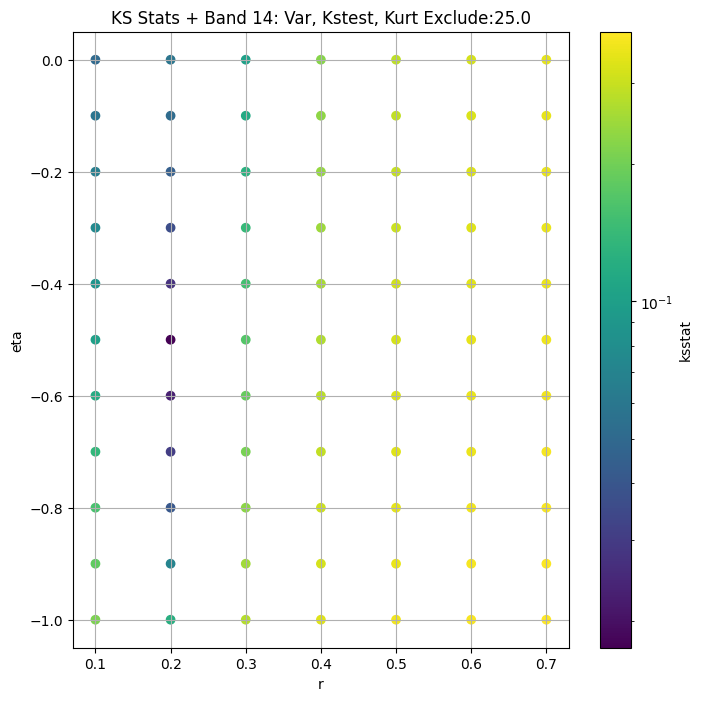

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.01633772720015314 71406210.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.018217552925985703 68996670.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.018749530090067523 67347860.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.01813842613319183 65967296.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.018909930538071662 64756252.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.02067792526112988 62669216.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.020237768991999916 60884910.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.021349482004549114 59310584.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.022653726861435186 57893444.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.022103890920470826 56600396.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.02396210947511912 53269440.0
Number of samples: 100000, Without approximation : 100000.0


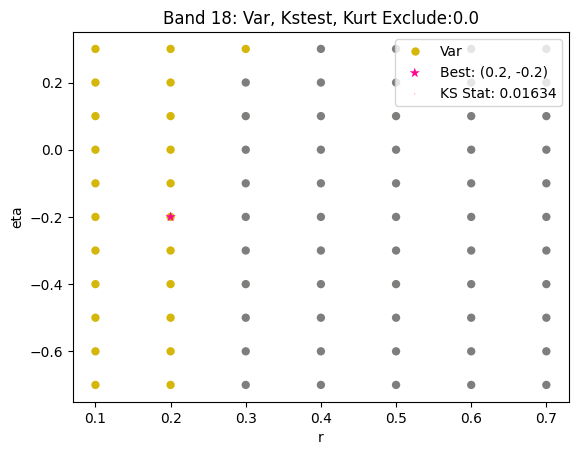

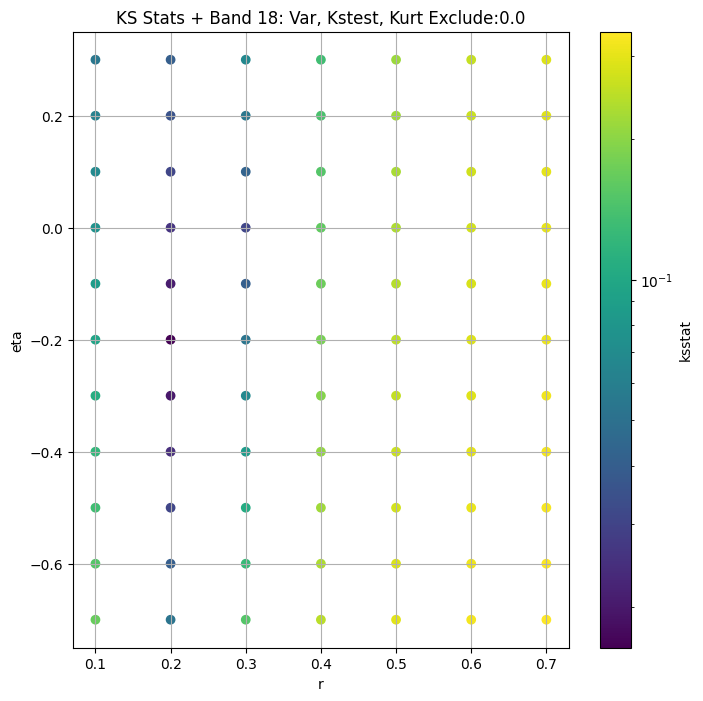

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.01509285839553795 27985542.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.01601733359203683 26688244.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.015075888122371595 25857082.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.015900793907419025 25181166.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.017172517911497237 24599952.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.019204177546345402 23622358.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.018090015139720417 22808826.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.019080420338439055 22106318.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.020596287727339374 21485018.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.021487852083984404 20925522.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.022657437862292795 19498954.0
Number of samples: 100000, Without approximation : 100000.0


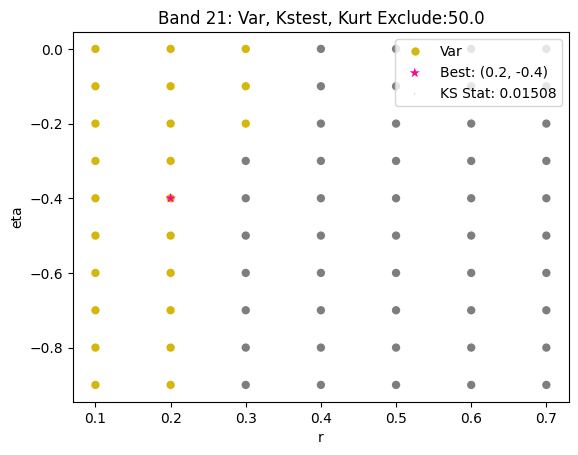

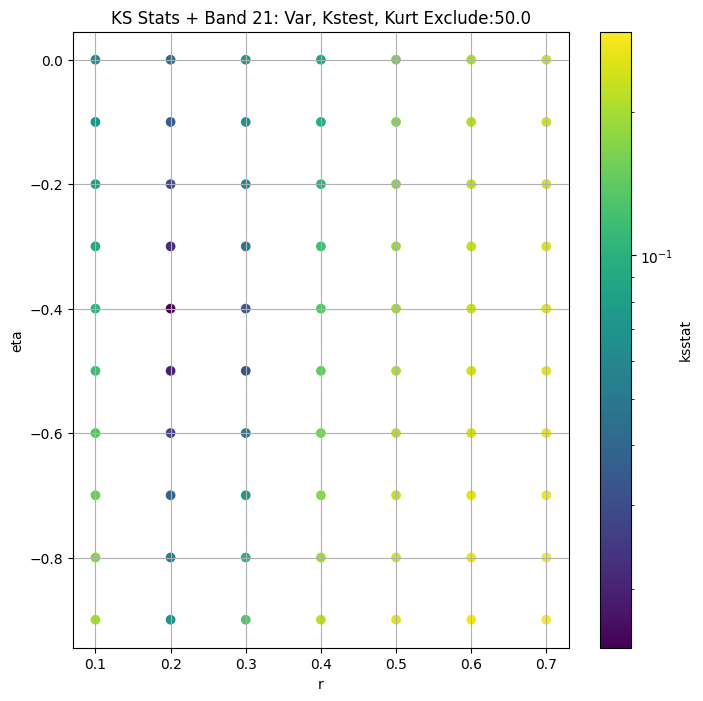

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.008123430101493523 23399628.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.009417295760407729 22270910.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.010497648386800451 21403196.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.01149691232825567 20653688.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.012455957703306875 19984034.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.01437436309813546 18814270.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.013641931024077347 17808166.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.0125559822893333 16922080.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.013828652598533275 16129314.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.015066689135118327 15412248.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.01869562387435242 13602799.0
Number of samples: 100000, Without approximation : 100000.0


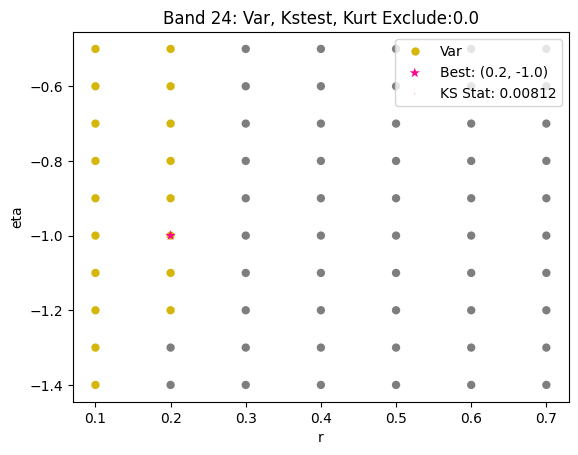

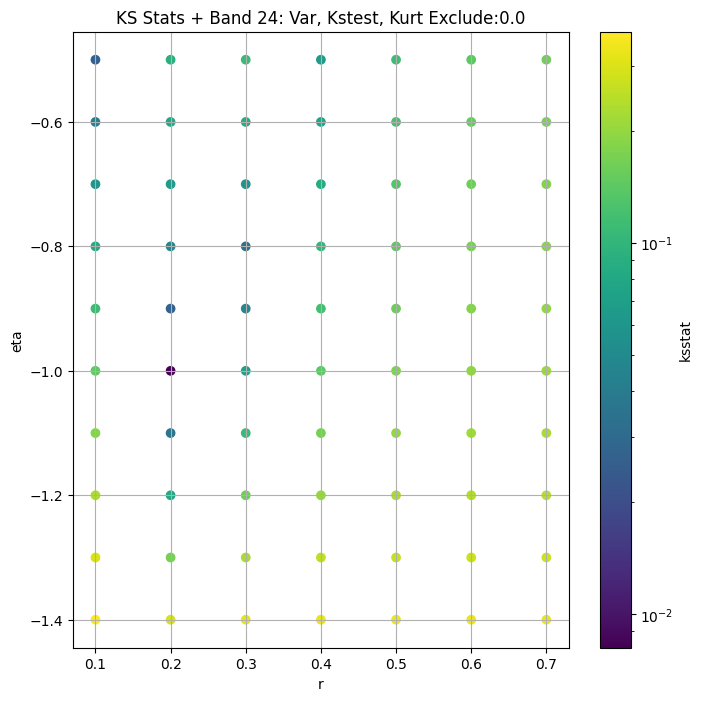

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.013502999530075277 11426148.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.012111942350671923 10809536.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.010087947349549875 10333821.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.010086715070684926 9923404.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.01113126103200851 9557462.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.013120395348160951 8919998.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.014946138288068456 8373733.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.01583609655348872 7894340.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.0168115284527941 7466906.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.017755490736680923 7081519.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.01433799177354167 6114641.0
Number of samples: 100000, Without approximation : 100000.0


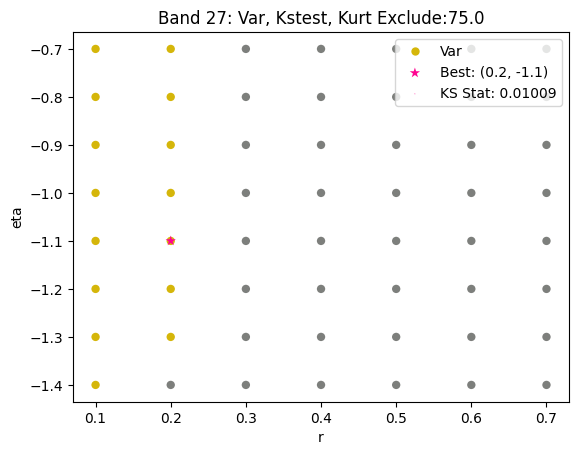

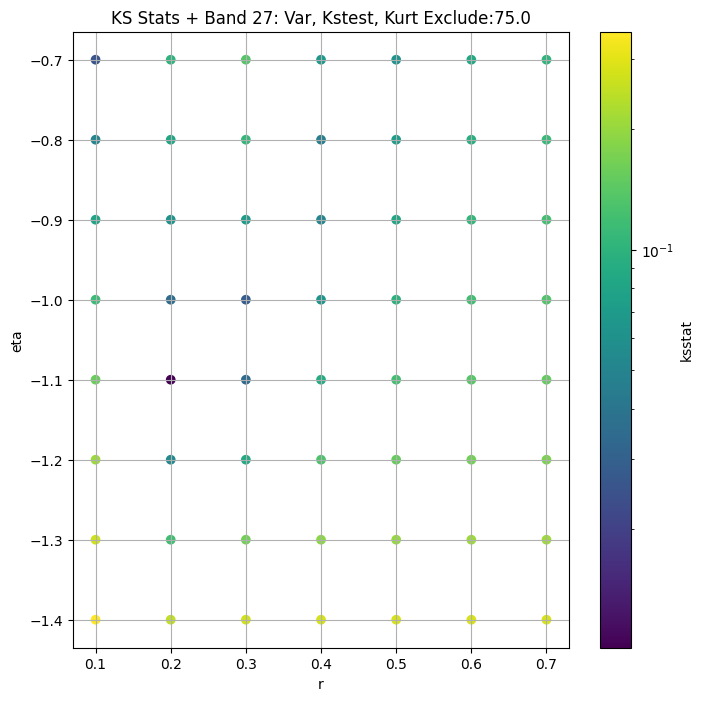

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.034244975077696915 307591.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.034053251028669074 279081.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.03392745278240816 262213.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.03381664771314952 248418.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.03371485656535067 236542.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.033529829689143864 216687.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.03336309594410358 200397.83


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.03320819197343061 186563.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.033062588941906945 174567.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03292460362044275 164009.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.03307052664254162 138530.92
Number of samples: 100000, Without approximation : 100000.0


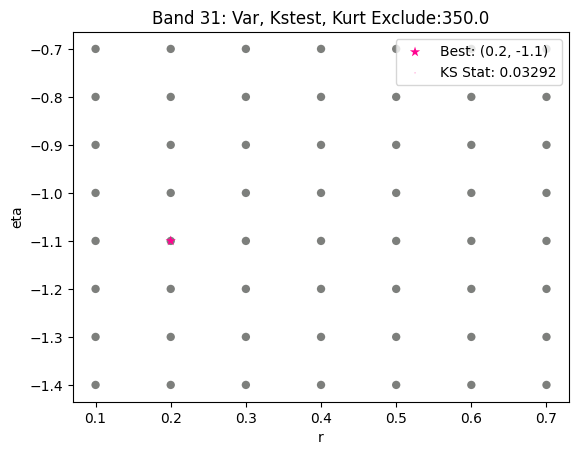

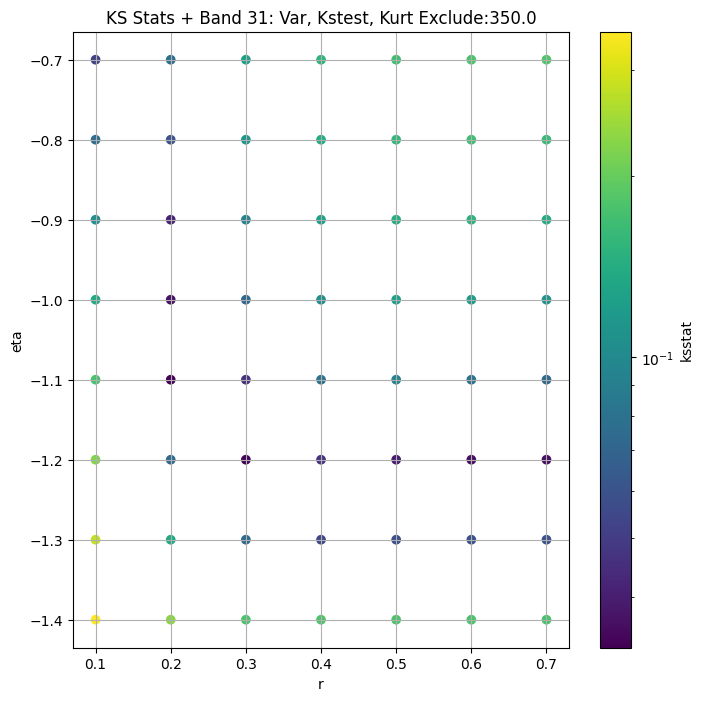

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304364e+08  8.450577e+08  1.021506e+09  11.473453    9.685472   
5     2.321099e+09  2.173827e+09  2.472827e+09   4.321749    3.780649   
8     1.711880e+09  1.608208e+09  1.819152e+09   3.817738    3.300339   
11    1.487492e+09  1.403327e+09  1.572967e+09   2.947570    2.643493   
14    3.505658e+08  3.214803e+08  3.808777e+08   8.853598    7.760434   
18    7.140621e+07  6.547071e+07  7.783148e+07   9.277631    7.097496   
21    2.798554e+07  2.521406e+07  3.104261e+07  14.152540   10.132266   
24    2.339963e+07  2.047373e+07  2.657507e+07  23.594416   19.813868   
27    1.142615e+07  9.846249e+06  1.313120e+07  29.143429   24.490961   
31    3.075916e+05  2.548352e+05  3.733561e+05  52.778656   33.753050   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.096589       100000.0             0.023594        0.1          0.0   
5       4.902878       100000.0             0.032372        0.2         -0.1   
8       4.358519       100000.0             0.024266        0.2          0.4   
11      3.266759       100000.0             0.030990        0.2          0.1   
14     10.020346       100000.0             0.017476        0.2         -0.5   
18     12.407567       100000.0             0.016338        0.2         -0.2   
21     20.440014       100000.0             0.015076        0.2         -0.4   
24     27.847523       100000.0             0.008123        0.2         -1.0   
27     34.455246       100000.0             0.010087        0.2         -1.1   
31    124.280266       100000.0             0.032925        0.2         -1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000131                     0.0        9.304364e+08   
5      41224.981241                    25.0        2.285513e+09   
8       8843.391932                     0.0        1.711880e+09   
11     15356.977778                    50.0        1.459527e+09   
14     22646.774603                    25.0        3.424192e+08   
18      1727.545603                     0.0        7.140621e+07   
21      1194.262161                    50.0        2.585708e+07   
24     16623.112354                     0.0        2.339963e+07   
27     13782.505556                    75.0        9.923404e+06   
31       227.791319                   350.0        1.640098e+05   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
5                    0.004293  
8                    0.004293  
11                   0.004293  
14                   0.004293  
18                   0.004293  
21                   0.004293  
24                   0.004293  
27                   0.004293  
31                   0.004293

In [19]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [20]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.024313902865936154, var: 848405504.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.02398839105021844, var: 864398976.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.0233470725737861, var: 881881536.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.02262950303766542, var: 901789888.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.021624126848300396, var: 930436352.0
Number of samples: 100000, Without approximation : 100000.0


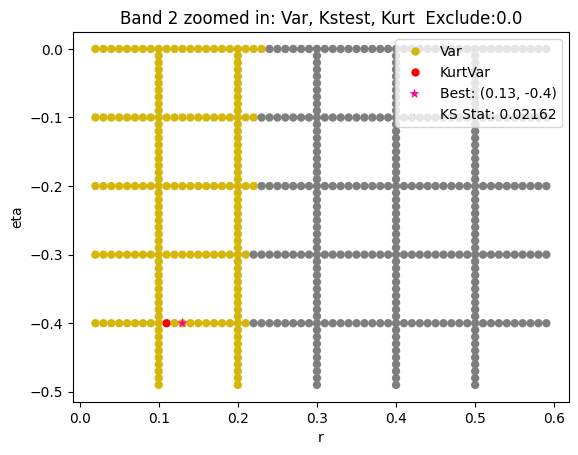

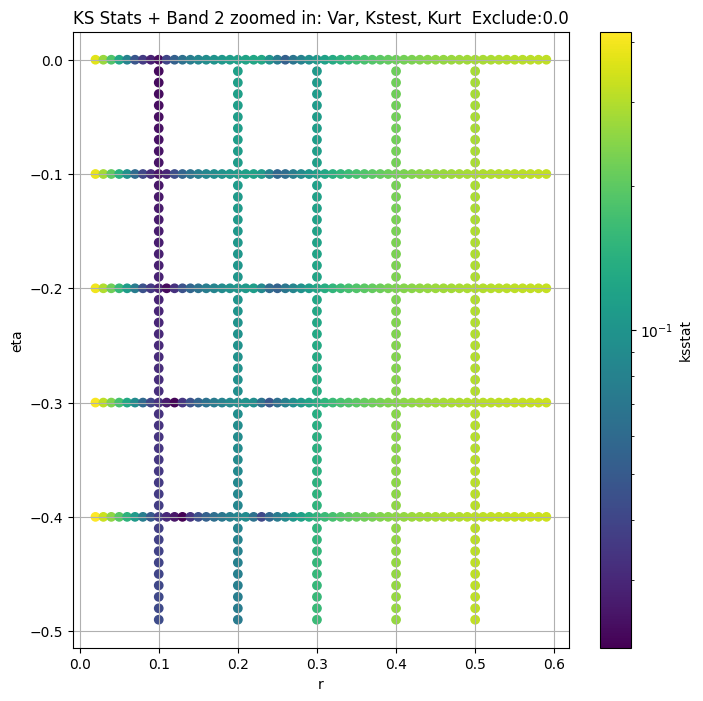

Band 5


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 100 = 125, ksstat: 0.03323219115588974, var: 2181091328.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 75 = 100, ksstat: 0.03290221675767481, var: 2204409600.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 50 = 75, ksstat: 0.032570297812044624, var: 2229220864.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 25 = 50, ksstat: 0.03245749291176031, var: 2255953920.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 0 = 25, ksstat: 0.03202768950677293, var: 2285512960.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + -25 = 0, ksstat: 0.03178294065537807, var: 2321099008.0
Number of samples: 100000, Without approximation : 100000.0


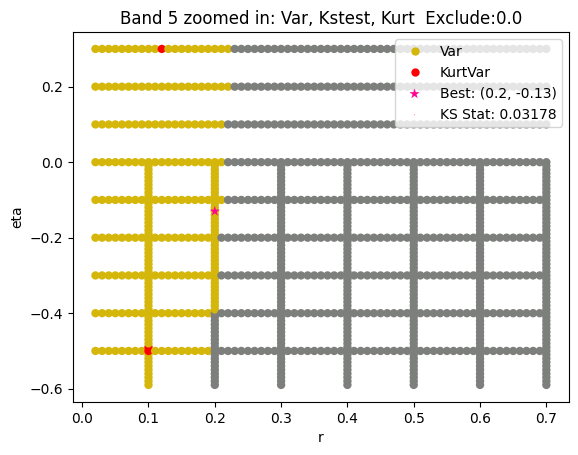

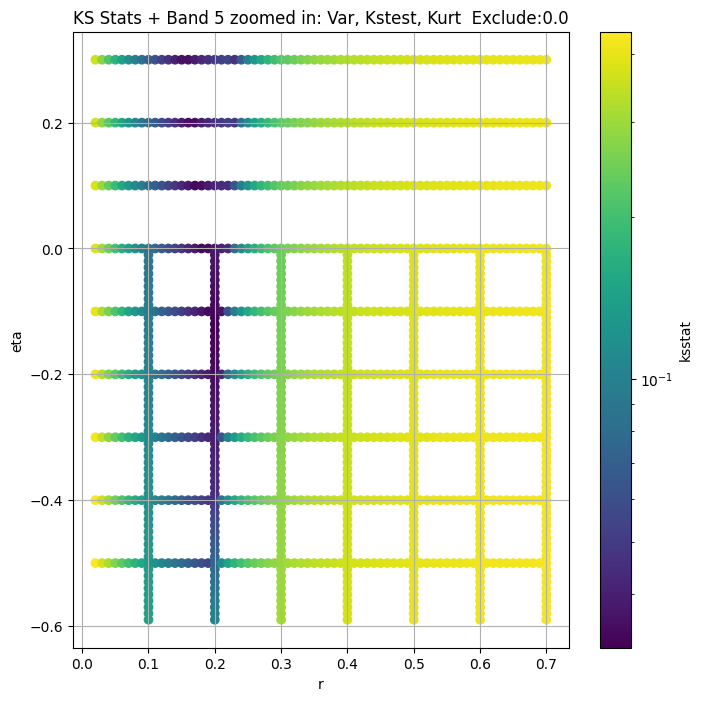

Band 8


  0%|          | 0/684 [00:00<?, ?it/s]

Finding Minimum after computing 684 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.025137706975706817, var: 1627256832.0


  0%|          | 0/684 [00:00<?, ?it/s]

Finding Minimum after computing 684 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.02434256347411569, var: 1645341696.0


  0%|          | 0/684 [00:00<?, ?it/s]

Finding Minimum after computing 684 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.024421324787787246, var: 1665008384.0


  0%|          | 0/684 [00:00<?, ?it/s]

Finding Minimum after computing 684 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.02480576792163708, var: 1686694912.0


  0%|          | 0/684 [00:00<?, ?it/s]

Finding Minimum after computing 684 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.02410054253713903, var: 1711880320.0
Number of samples: 100000, Without approximation : 100000.0


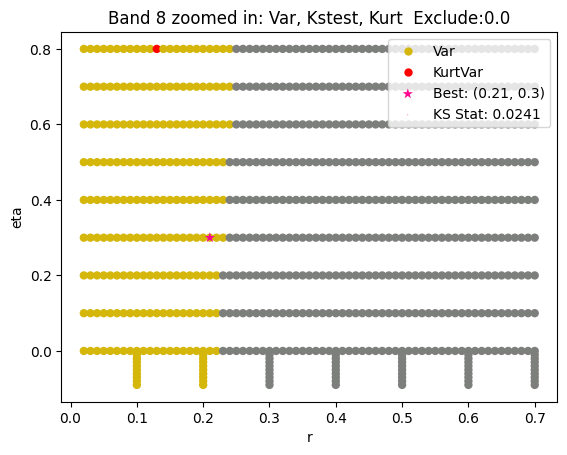

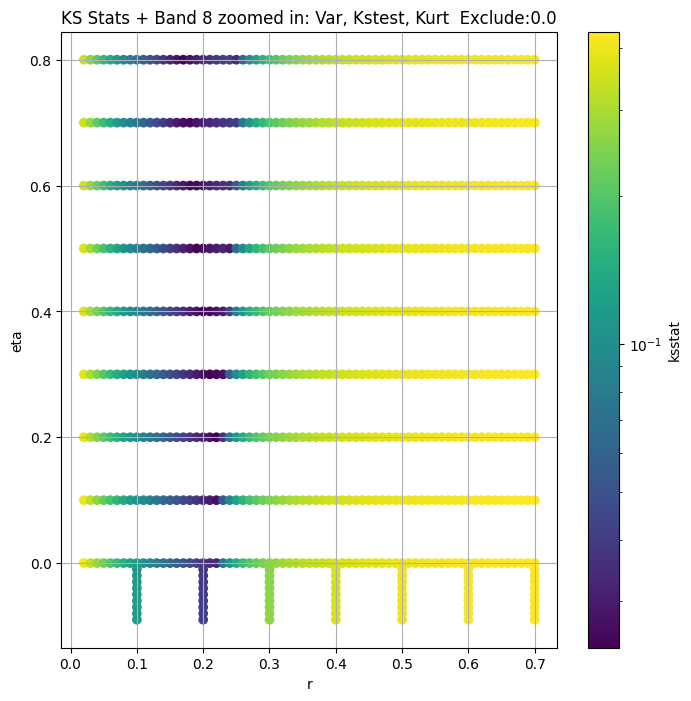

Band 11


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 100 = 150, ksstat: 0.03186873311343047, var: 1413168512.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 75 = 125, ksstat: 0.032165586886486464, var: 1424061696.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 50 = 100, ksstat: 0.03177249713304782, var: 1435361152.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 25 = 75, ksstat: 0.031275022910493055, var: 1447144704.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 0 = 50, ksstat: 0.030922012185747486, var: 1459527168.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + -25 = 25, ksstat: 0.030374323757770702, var: 1472722688.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + -50 = 0, ksstat: 0.030515151995650747, var: 1487492096.0
Number of samples: 100000, Without approximation : 100000.0


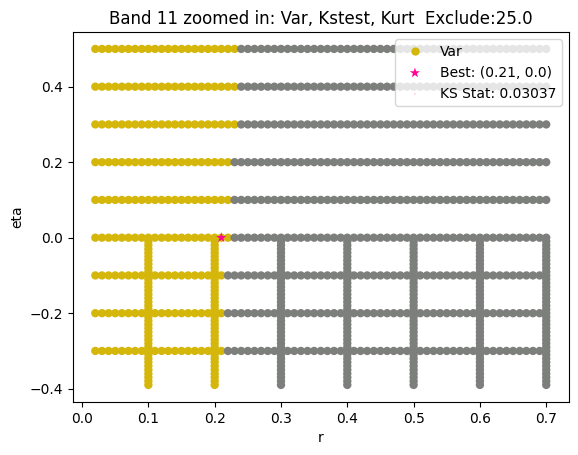

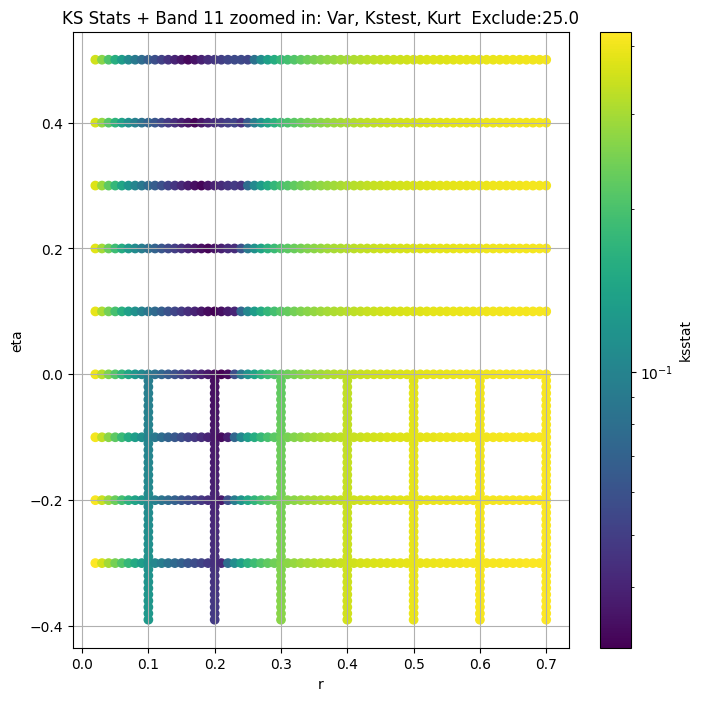

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.01935585734222975, var: 318796416.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.018958862829224724, var: 323994016.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.018524646508123715, var: 329574240.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.018039315256248842, var: 335647488.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.017476101350395193, var: 342419232.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.017221548239579873, var: 350565760.0
Number of samples: 100000, Without approximation : 100000.0


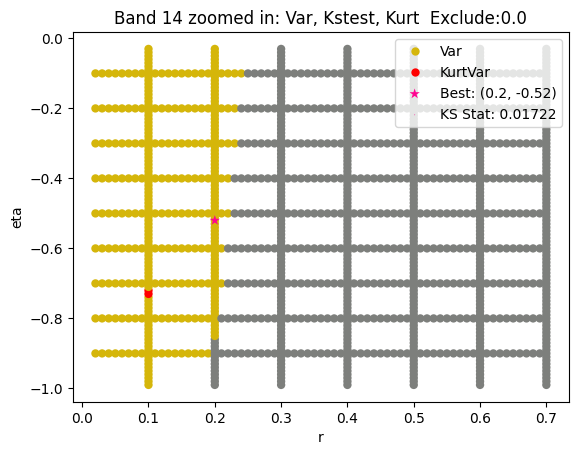

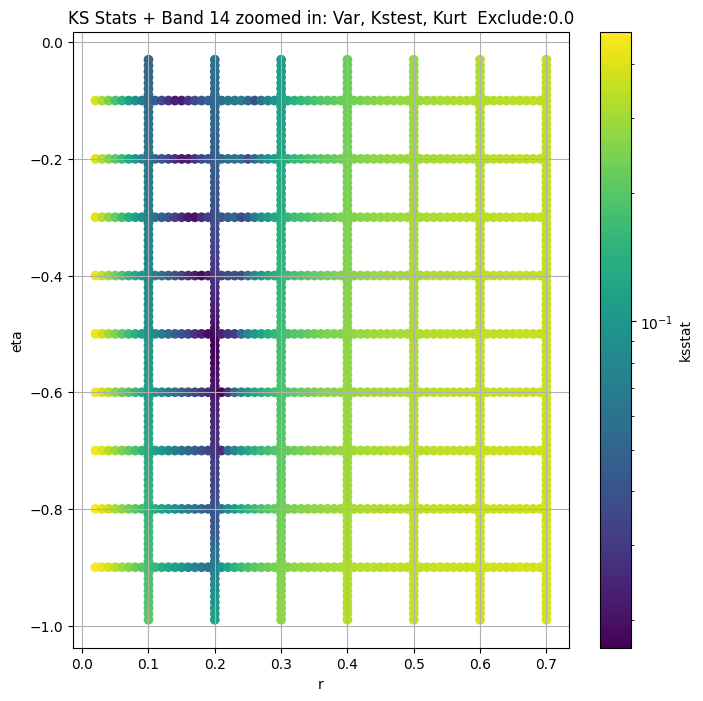

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.017318623955085988, var: 64756252.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.01632426471397208, var: 65967296.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.016769203689430023, var: 67347856.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.01568373536939538, var: 68996672.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.015324345515987936, var: 71406208.0
Number of samples: 100000, Without approximation : 100000.0


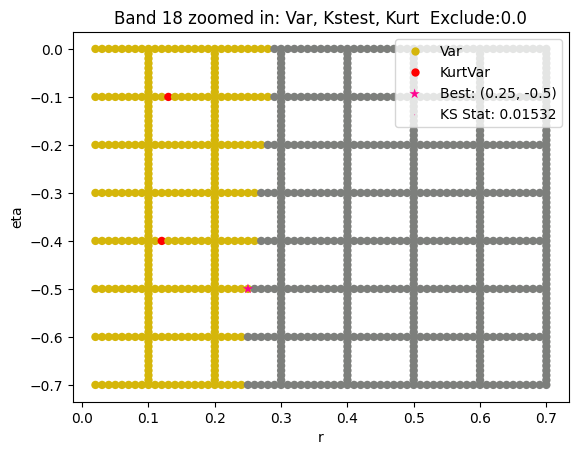

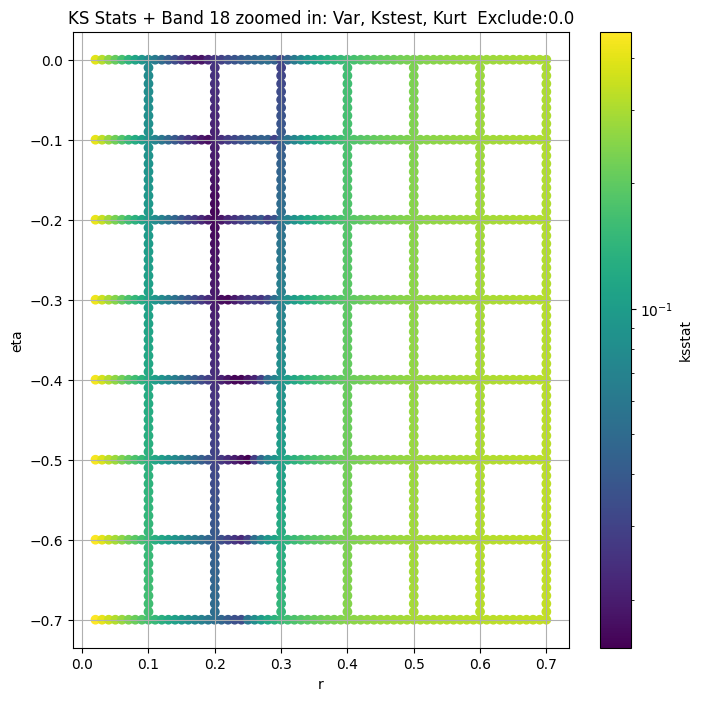

Band 21


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 100 = 150, ksstat: 0.015408197681278171, var: 23622358.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 75 = 125, ksstat: 0.014401964658916591, var: 24085774.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 50 = 100, ksstat: 0.014400095992556095, var: 24599952.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 25 = 75, ksstat: 0.014226732408394463, var: 25181166.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 0 = 50, ksstat: 0.012853802378903878, var: 25857082.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + -25 = 25, ksstat: 0.011656712812535802, var: 26688244.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + -50 = 0, ksstat: 0.011476162708512039, var: 27985542.0
Number of samples: 100000, Without approximation : 100000.0


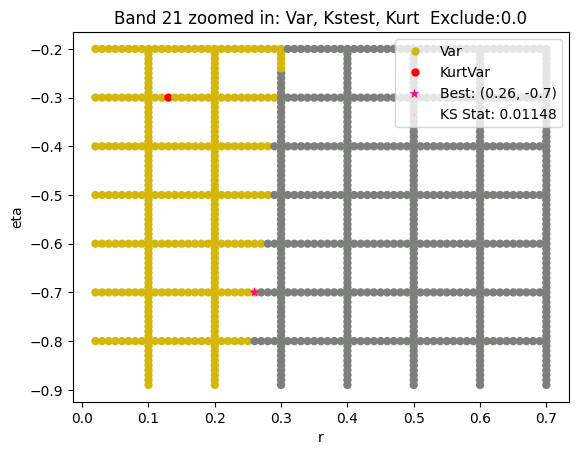

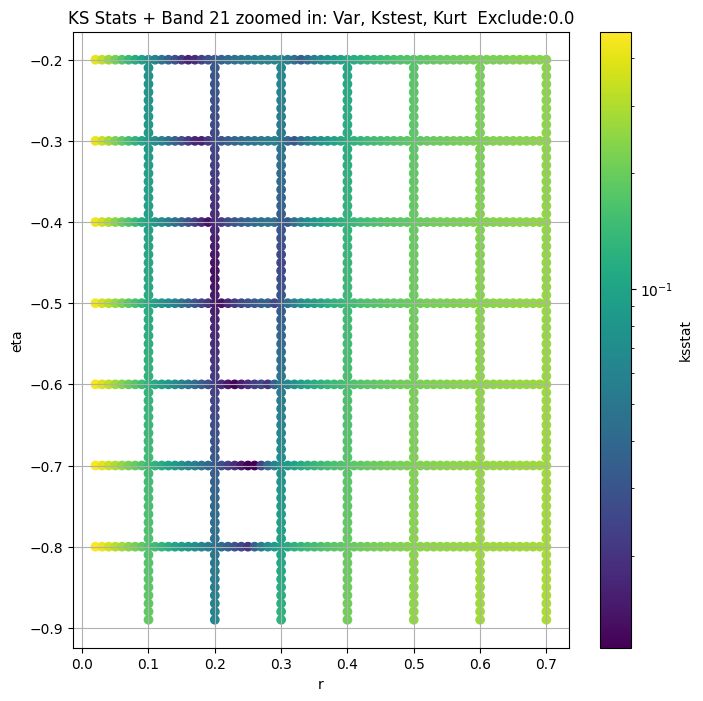

Band 24


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 100 = 100, ksstat: 0.008883136508558431, var: 19984034.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 75 = 75, ksstat: 0.009206712892407931, var: 20653688.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 50 = 50, ksstat: 0.008644363951950007, var: 21403196.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 25 = 25, ksstat: 0.007658129828812754, var: 22270910.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 0 = 0, ksstat: 0.0072569396089706695, var: 23399628.0
Number of samples: 100000, Without approximation : 100000.0


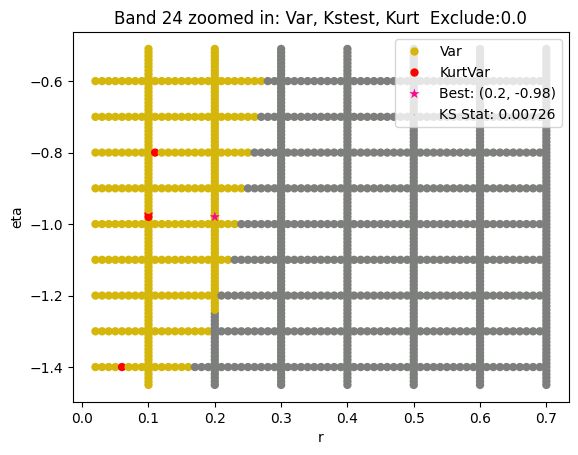

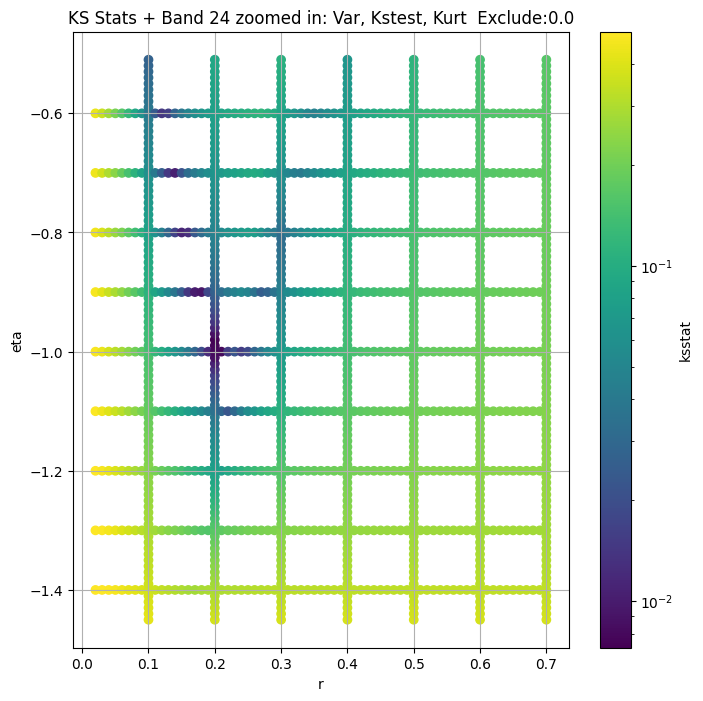

Band 27


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 100 = 175, ksstat: 0.010172412768877037, var: 8637292.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 75 = 150, ksstat: 0.01007421377152784, var: 8919998.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 50 = 125, ksstat: 0.009829314719178694, var: 9225222.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 25 = 100, ksstat: 0.009646736391491606, var: 9557462.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 0 = 75, ksstat: 0.010086715070684926, var: 9923404.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -25 = 50, ksstat: 0.010087947349549875, var: 10333821.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -50 = 25, ksstat: 0.011240095164177566, var: 10809536.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -75 = 0, ksstat: 0.011494893386462035, var: 11426148.0
Number of samples: 100000, Without approximation : 100000.0


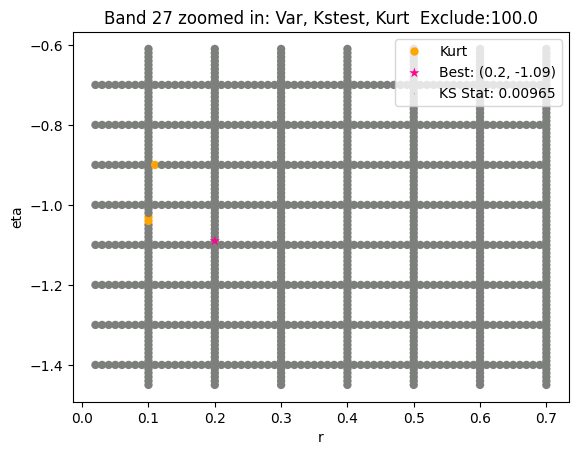

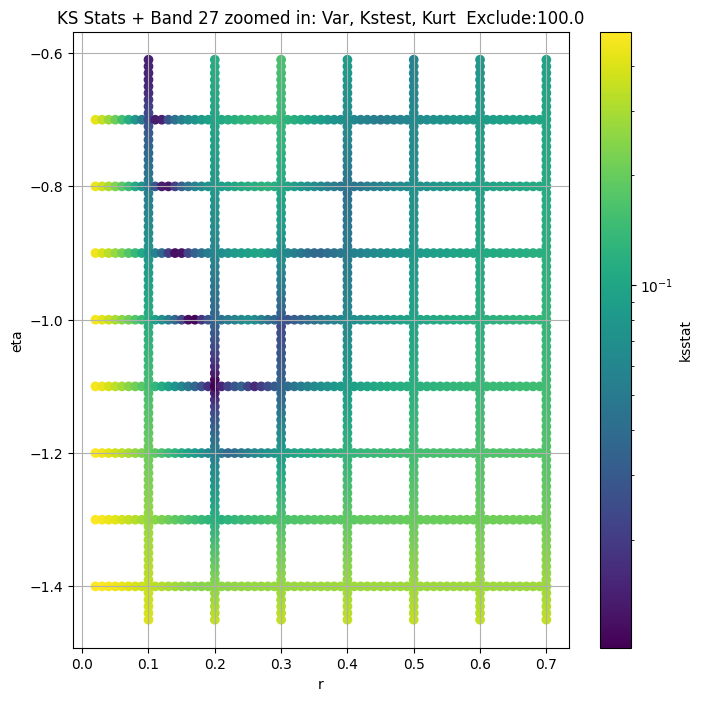

Band 31


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 100 = 450, ksstat: 0.026059682290274777, var: 146170.984375


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 75 = 425, ksstat: 0.026059682290274777, var: 150282.875


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 50 = 400, ksstat: 0.026059682290274777, var: 154612.34375


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 25 = 375, ksstat: 0.026059682290274777, var: 159180.375


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 0 = 350, ksstat: 0.026059682290274777, var: 164009.75


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -25 = 325, ksstat: 0.026059682290274777, var: 169128.015625


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -50 = 300, ksstat: 0.026059682290274777, var: 174567.96875


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -75 = 275, ksstat: 0.026059682290274777, var: 180364.453125


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -100 = 250, ksstat: 0.026059682290274777, var: 186563.53125
Number of samples: 100000, Without approximation : 100000.0


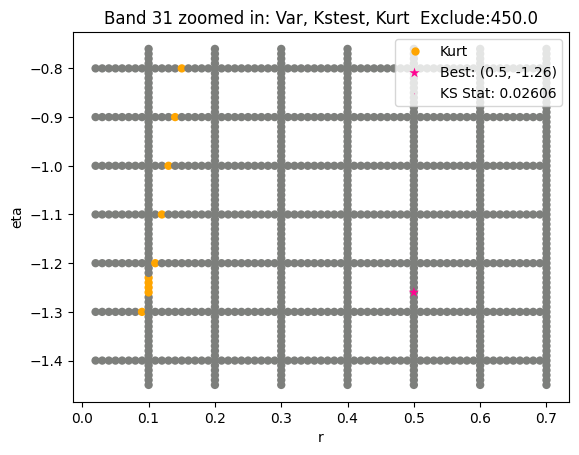

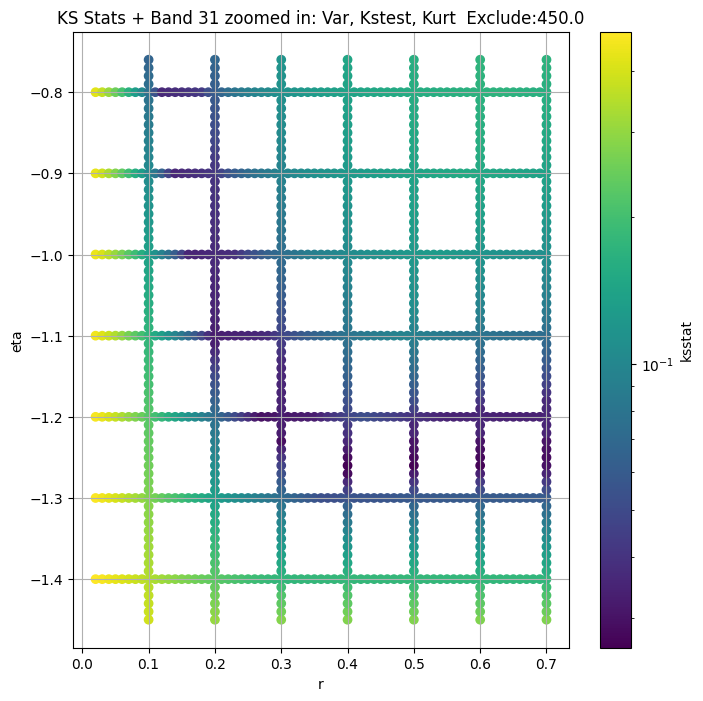

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304364e+08  8.450577e+08  1.021506e+09  11.473453    9.685472   
5     2.321099e+09  2.173827e+09  2.472827e+09   4.321749    3.780649   
8     1.711880e+09  1.608208e+09  1.819152e+09   3.817738    3.300339   
11    1.487492e+09  1.403327e+09  1.572967e+09   2.947570    2.643493   
14    3.505658e+08  3.214803e+08  3.808777e+08   8.853598    7.760434   
18    7.140621e+07  6.547071e+07  7.783148e+07   9.277631    7.097496   
21    2.798554e+07  2.521406e+07  3.104261e+07  14.152540   10.132266   
24    2.339963e+07  2.047373e+07  2.657507e+07  23.594416   19.813868   
27    1.142615e+07  9.846249e+06  1.313120e+07  29.143429   24.490961   
31    3.075916e+05  2.548352e+05  3.733561e+05  52.778656   33.753050   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.096589       100000.0             0.023594        0.1          0.0   
5       4.902878       100000.0             0.032372        0.2         -0.1   
8       4.358519       100000.0             0.024266        0.2          0.4   
11      3.266759       100000.0             0.030990        0.2          0.1   
14     10.020346       100000.0             0.017476        0.2         -0.5   
18     12.407567       100000.0             0.016338        0.2         -0.2   
21     20.440014       100000.0             0.015076        0.2         -0.4   
24     27.847523       100000.0             0.008123        0.2         -1.0   
27     34.455246       100000.0             0.010087        0.2         -1.1   
31    124.280266       100000.0             0.032925        0.2         -1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000131                     0.0        9.304364e+08   
5      41224.981241                    25.0        2.321099e+09   
8       8843.391932                     0.0        1.711880e+09   
11     15356.977778                    50.0        1.472723e+09   
14     22646.774603                    25.0        3.505658e+08   
18      1727.545603                     0.0        7.140621e+07   
21      1194.262161                    50.0        2.798554e+07   
24     16623.112354                     0.0        2.339963e+07   
27     13782.505556                    75.0        9.557462e+06   
31       227.791319                   350.0        1.461710e+05   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.021624    0.13     -0.40   
5                    0.004293          0.031783    0.20     -0.13   
8                    0.004293          0.024101    0.21      0.30   
11                   0.004293          0.030374    0.21      0.00   
14                   0.004293          0.017222    0.20     -0.52   
18                   0.004293          0.015324    0.25     -0.50   
21                   0.004293          0.011476    0.26     -0.70   
24                   0.004293          0.007257    0.20     -0.98   
27                   0.004293          0.009647    0.20     -1.09   
31                   0.004293          0.026060    0.50     -1.26   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2          6.042356                  0.0         3952  
5      45637.747200                  0.0         1756  
8      24969.364078                  0.0         3125  
11     43855.586842                 25.0         1975  
14     24995.119397                  0.0         6250  
18     85007.390476                  0.0         7908  
21     96455.702648                  0.0        14062  
24     14704.264636                

In [21]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

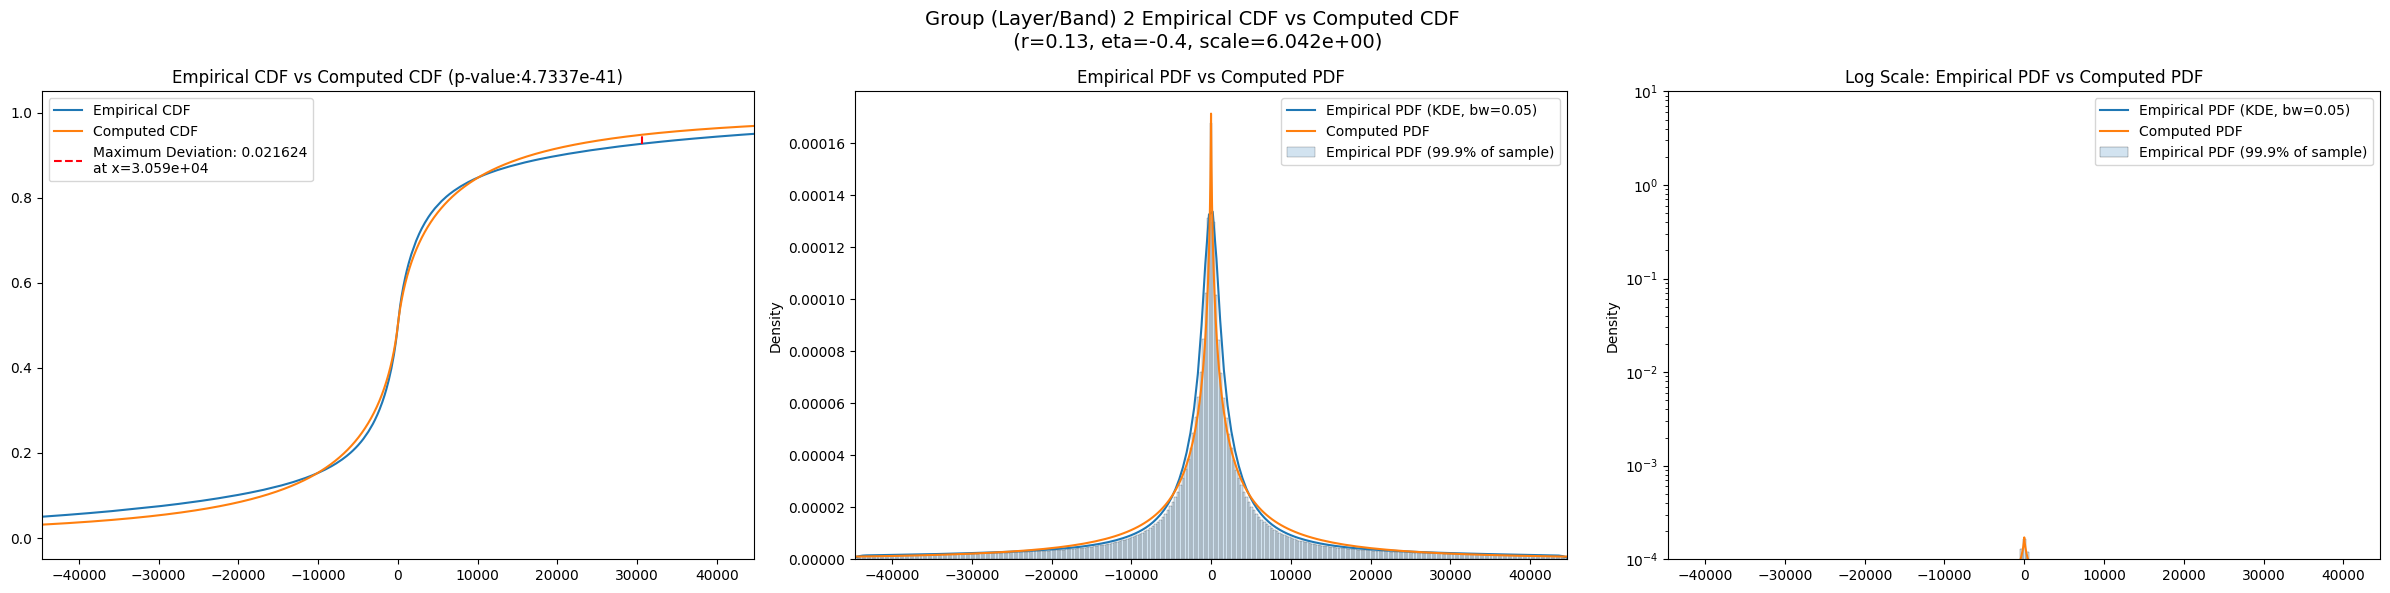

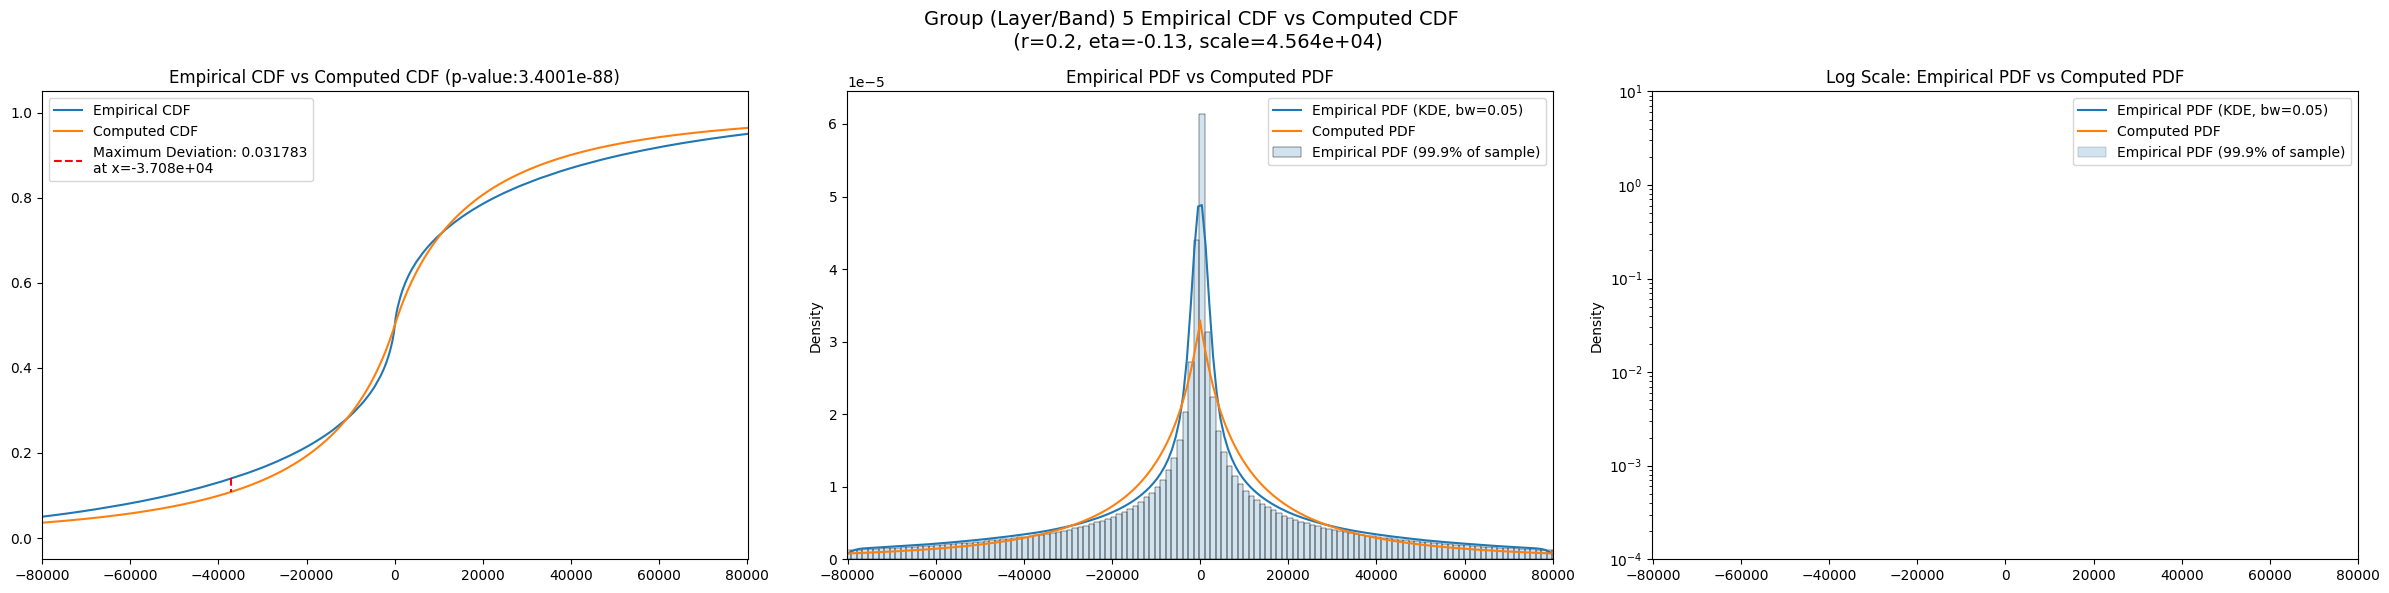

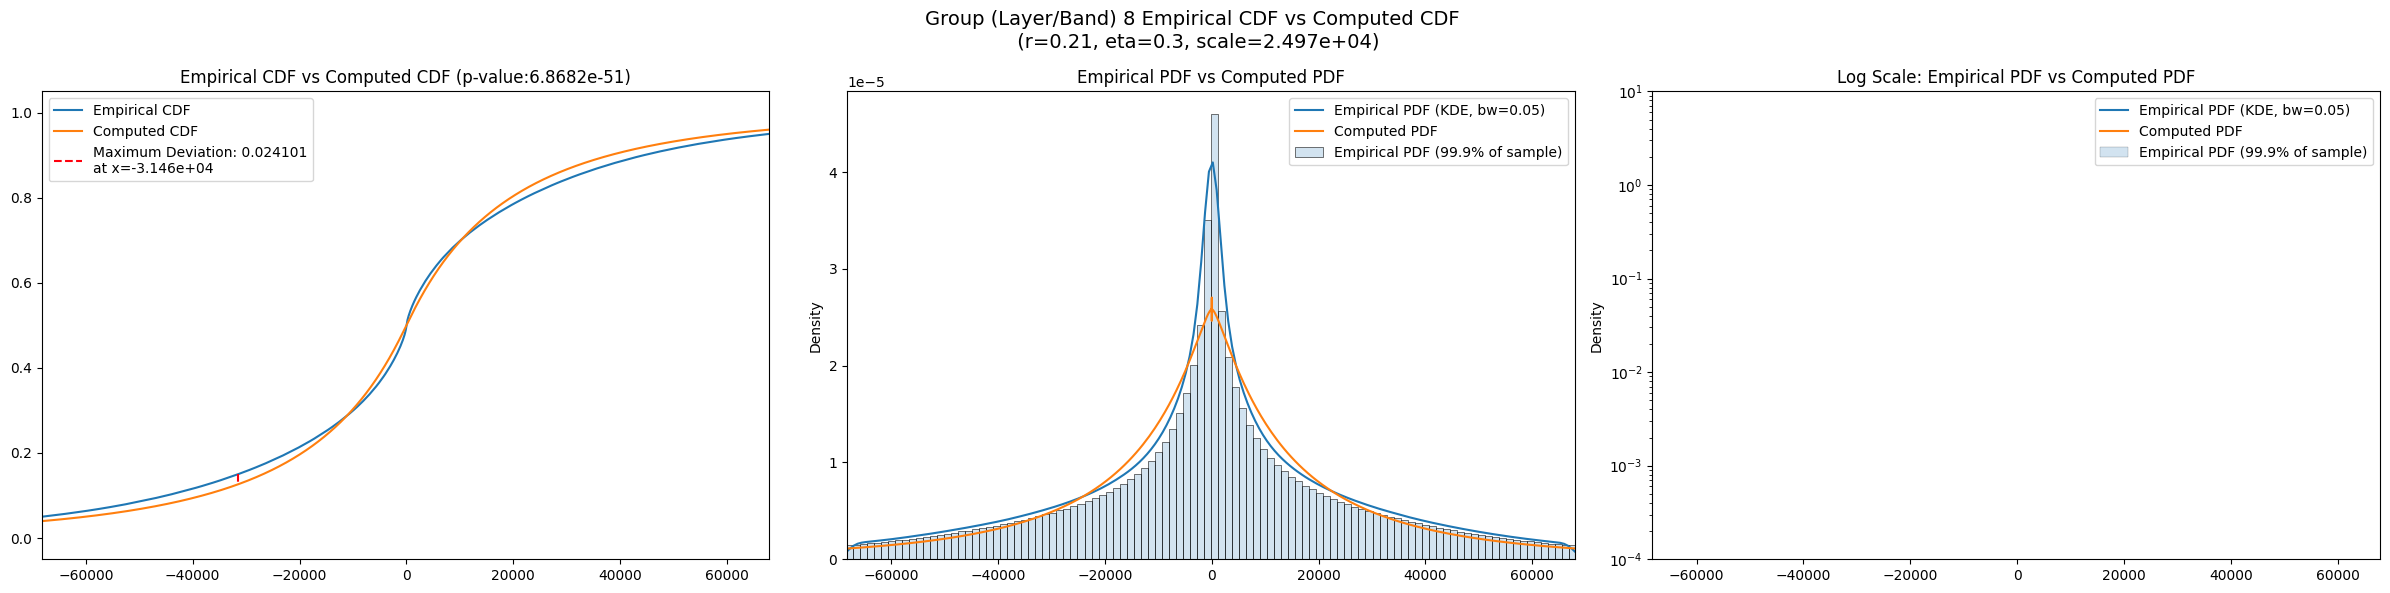

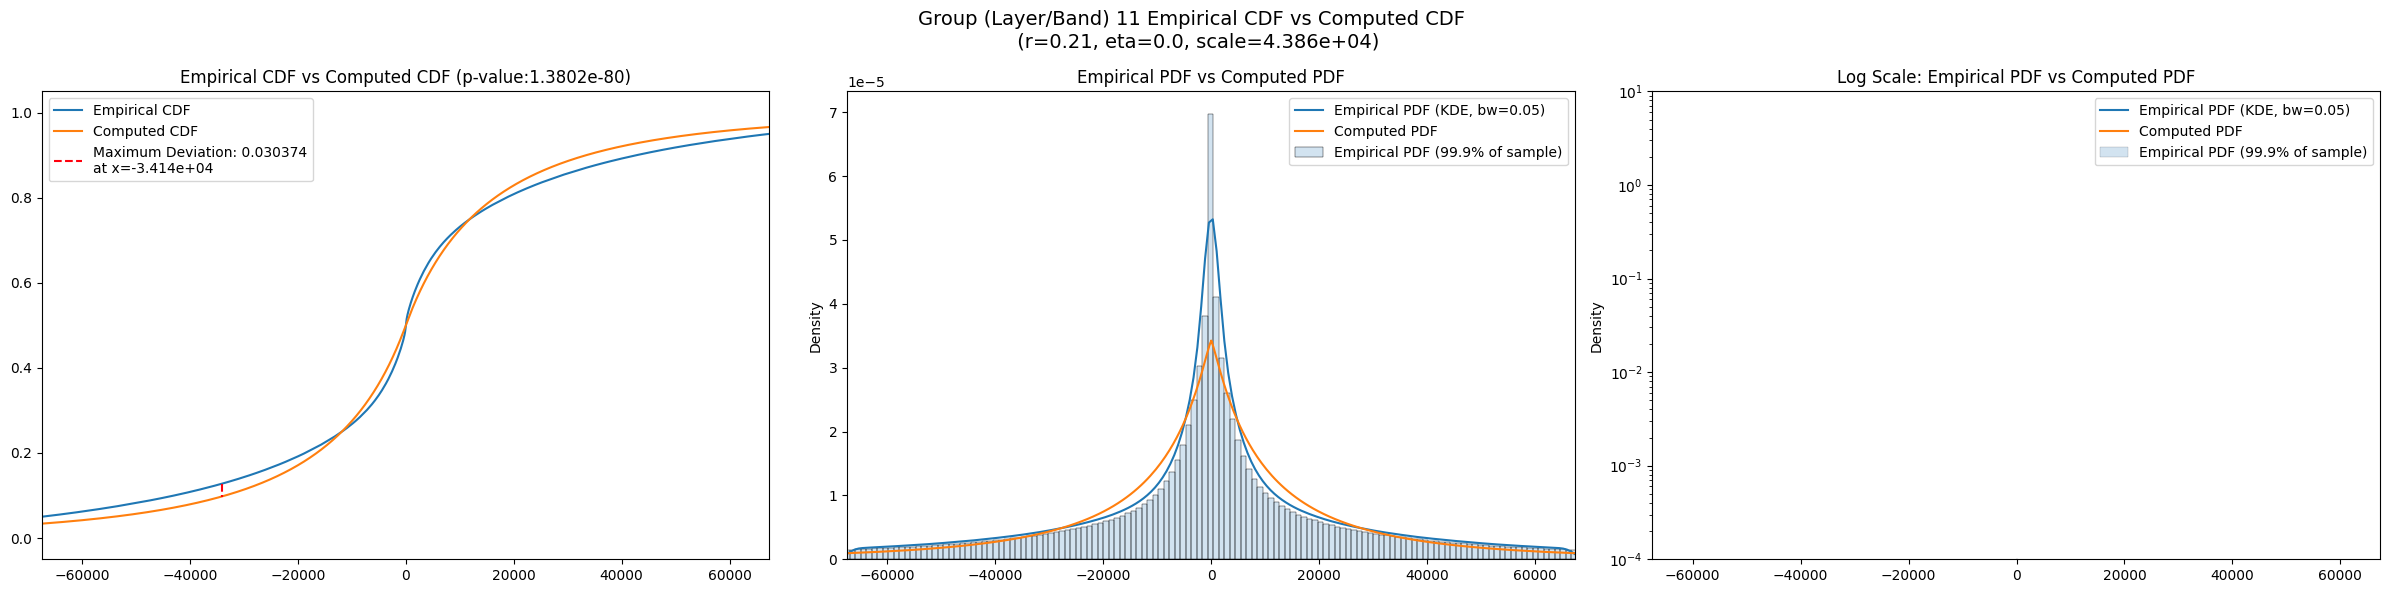

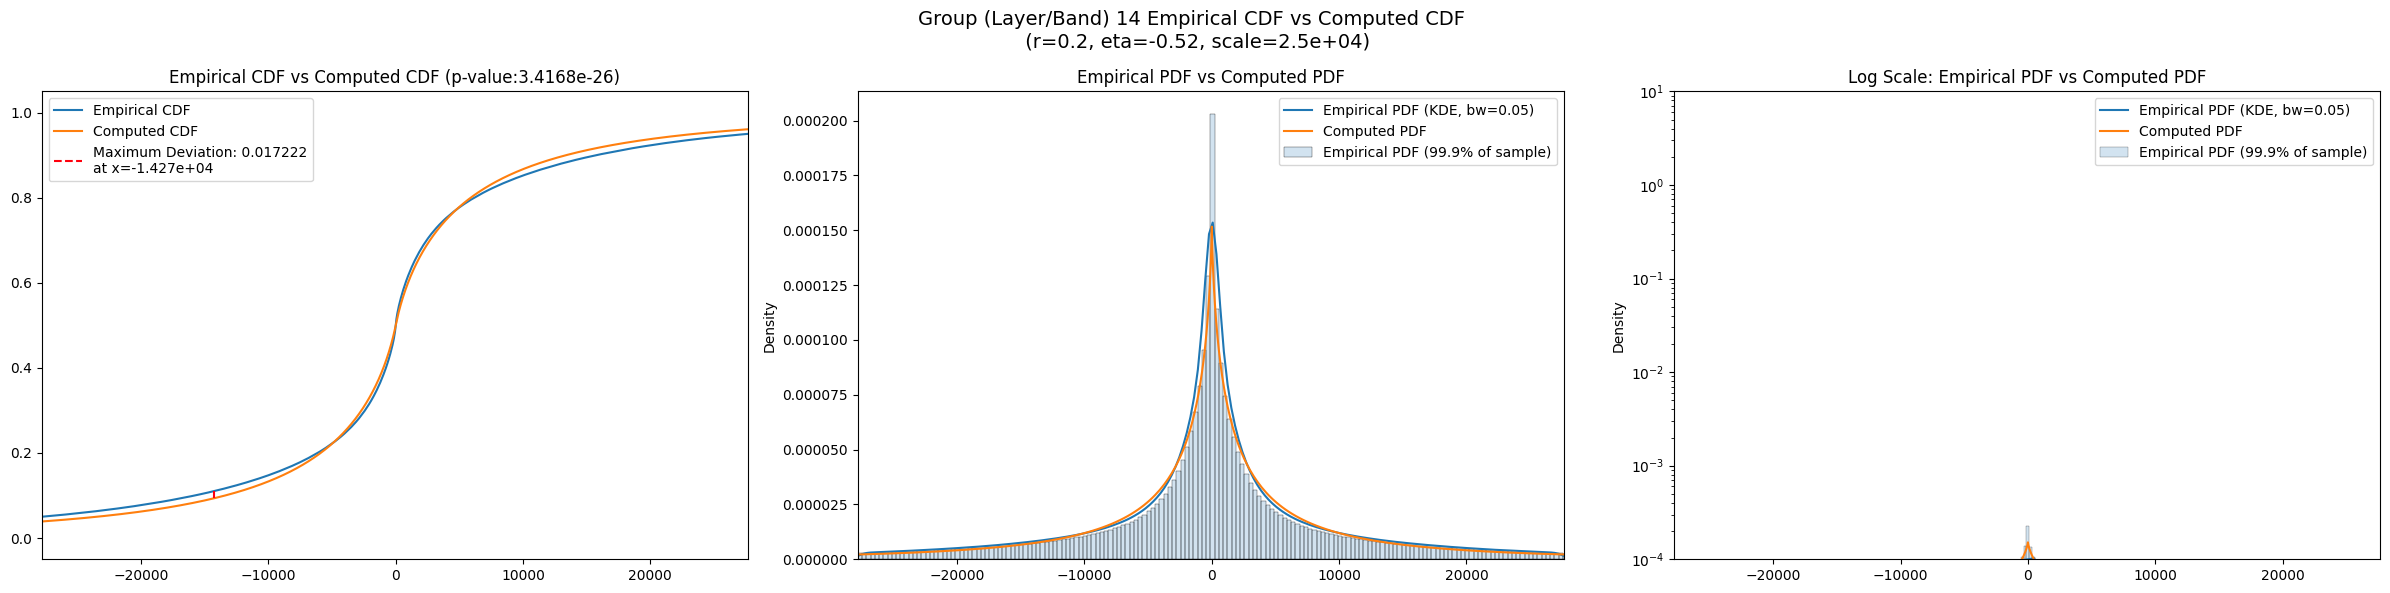

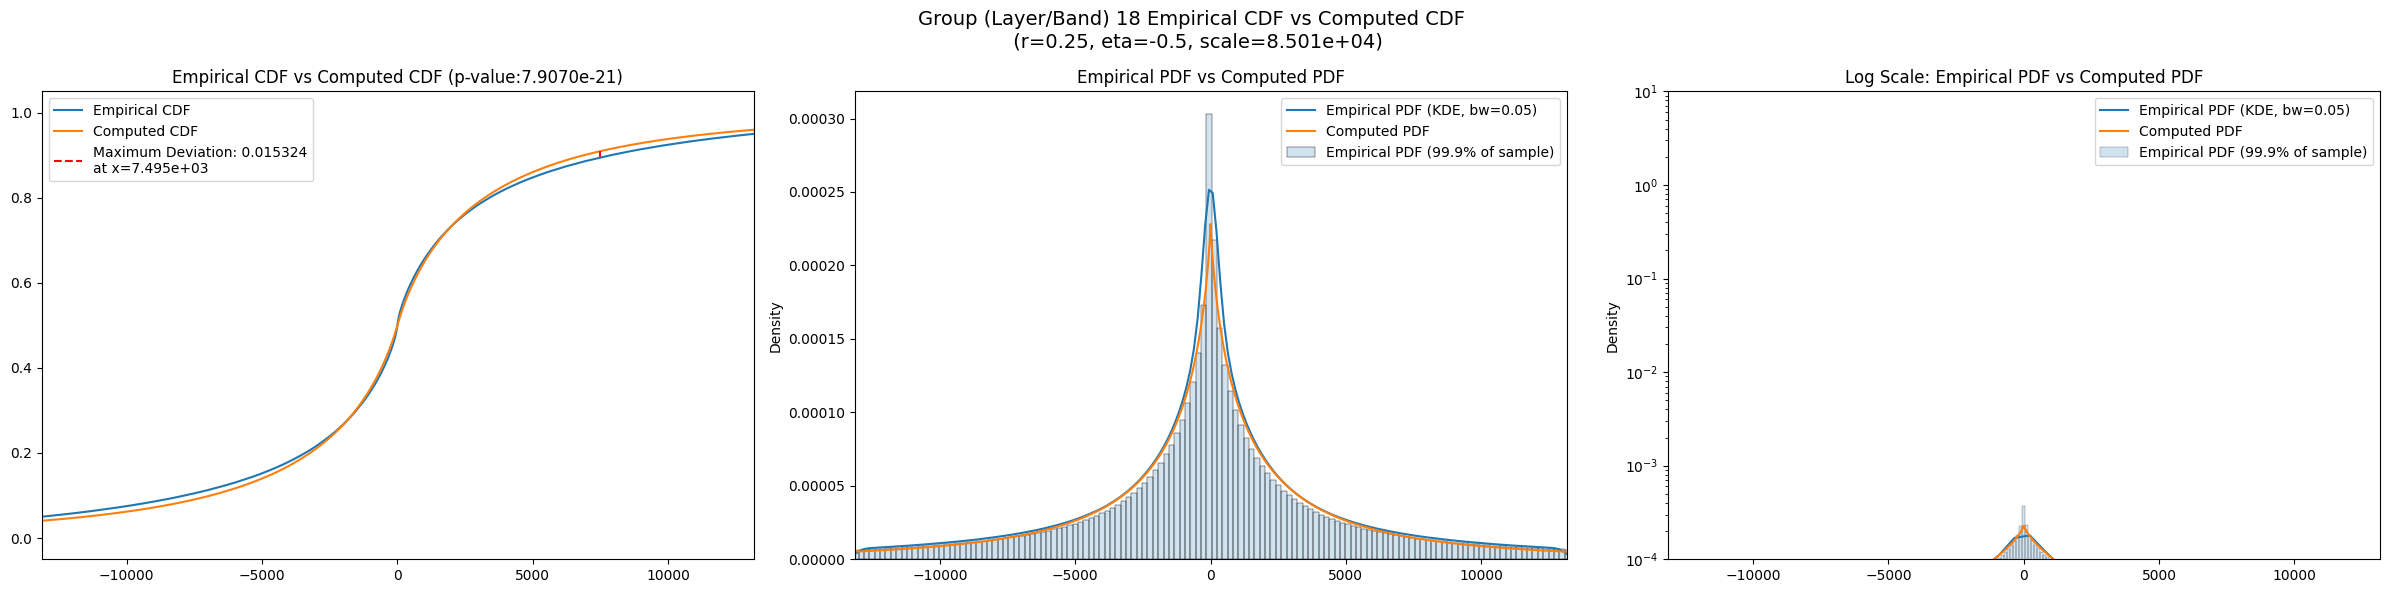

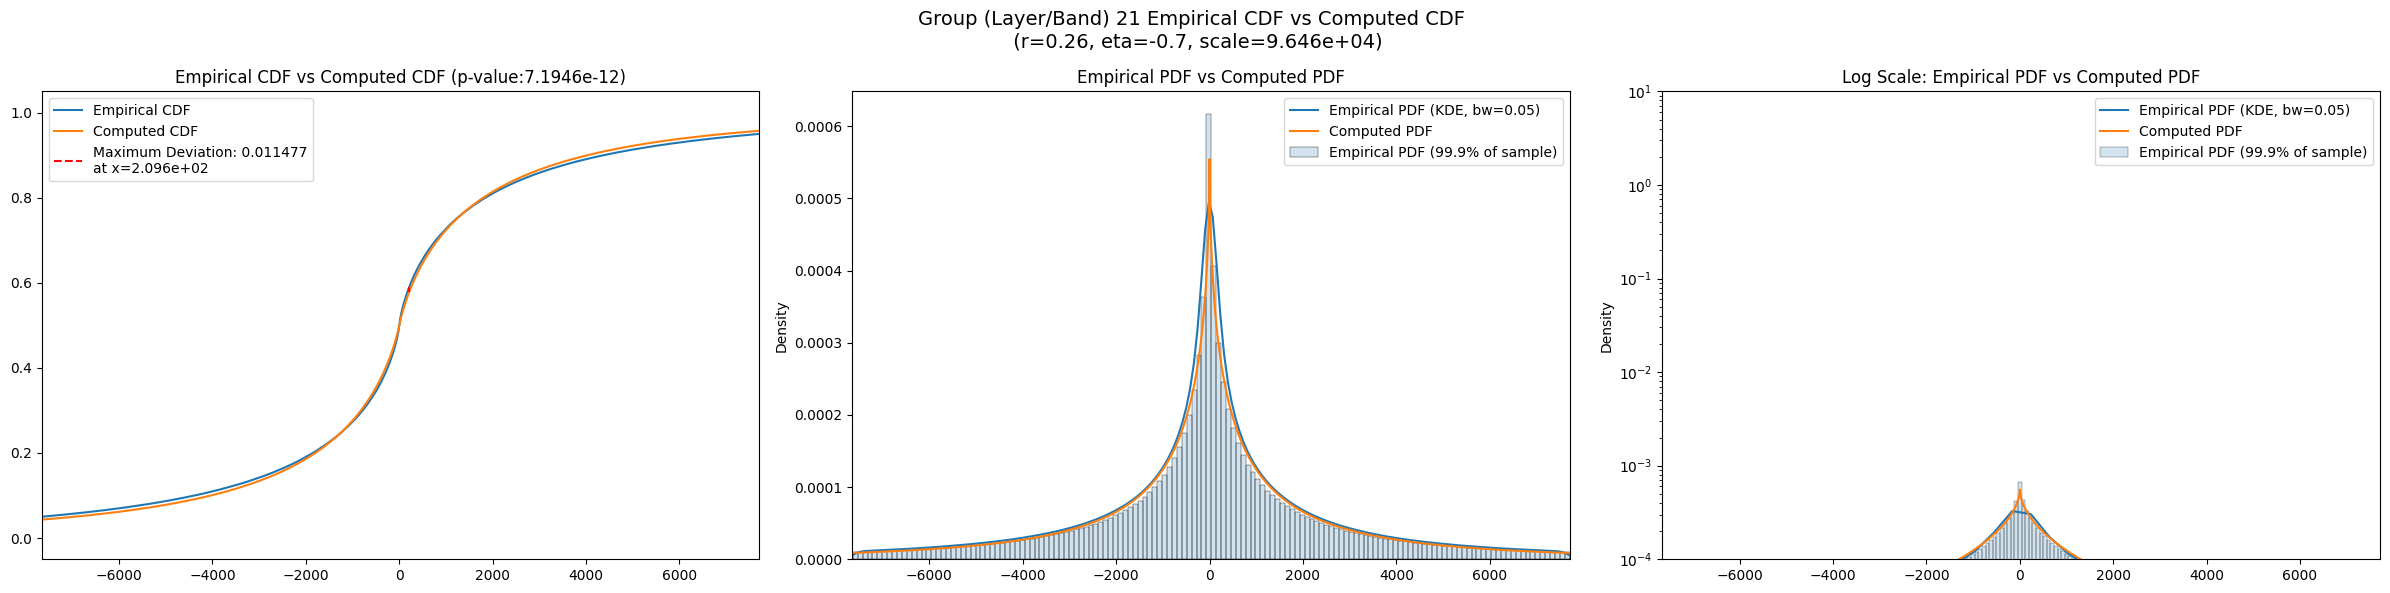

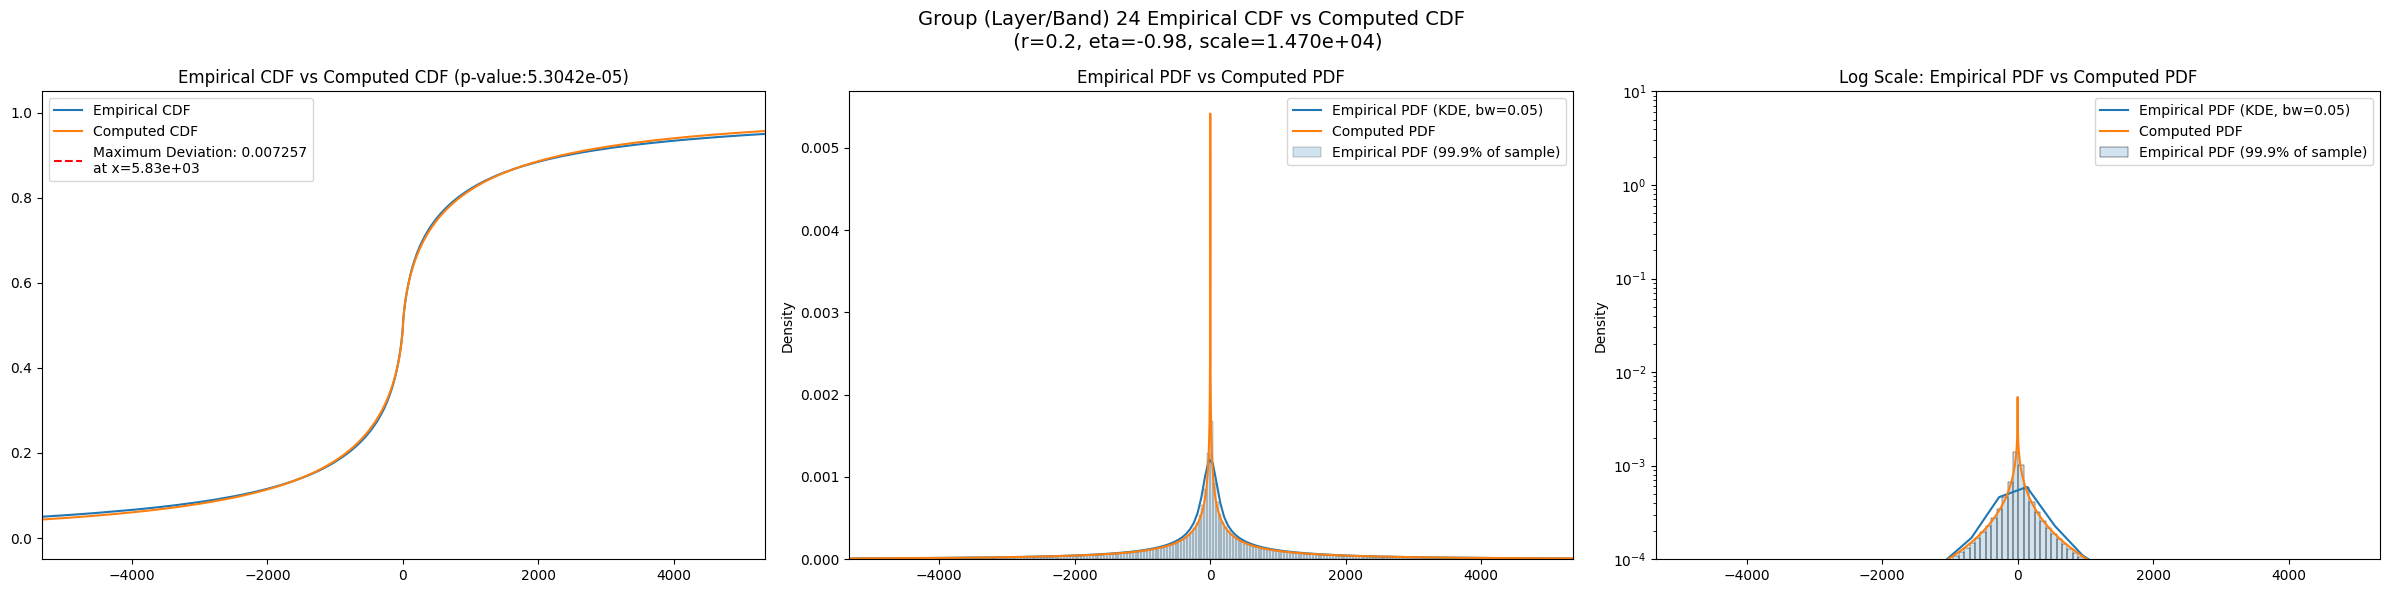

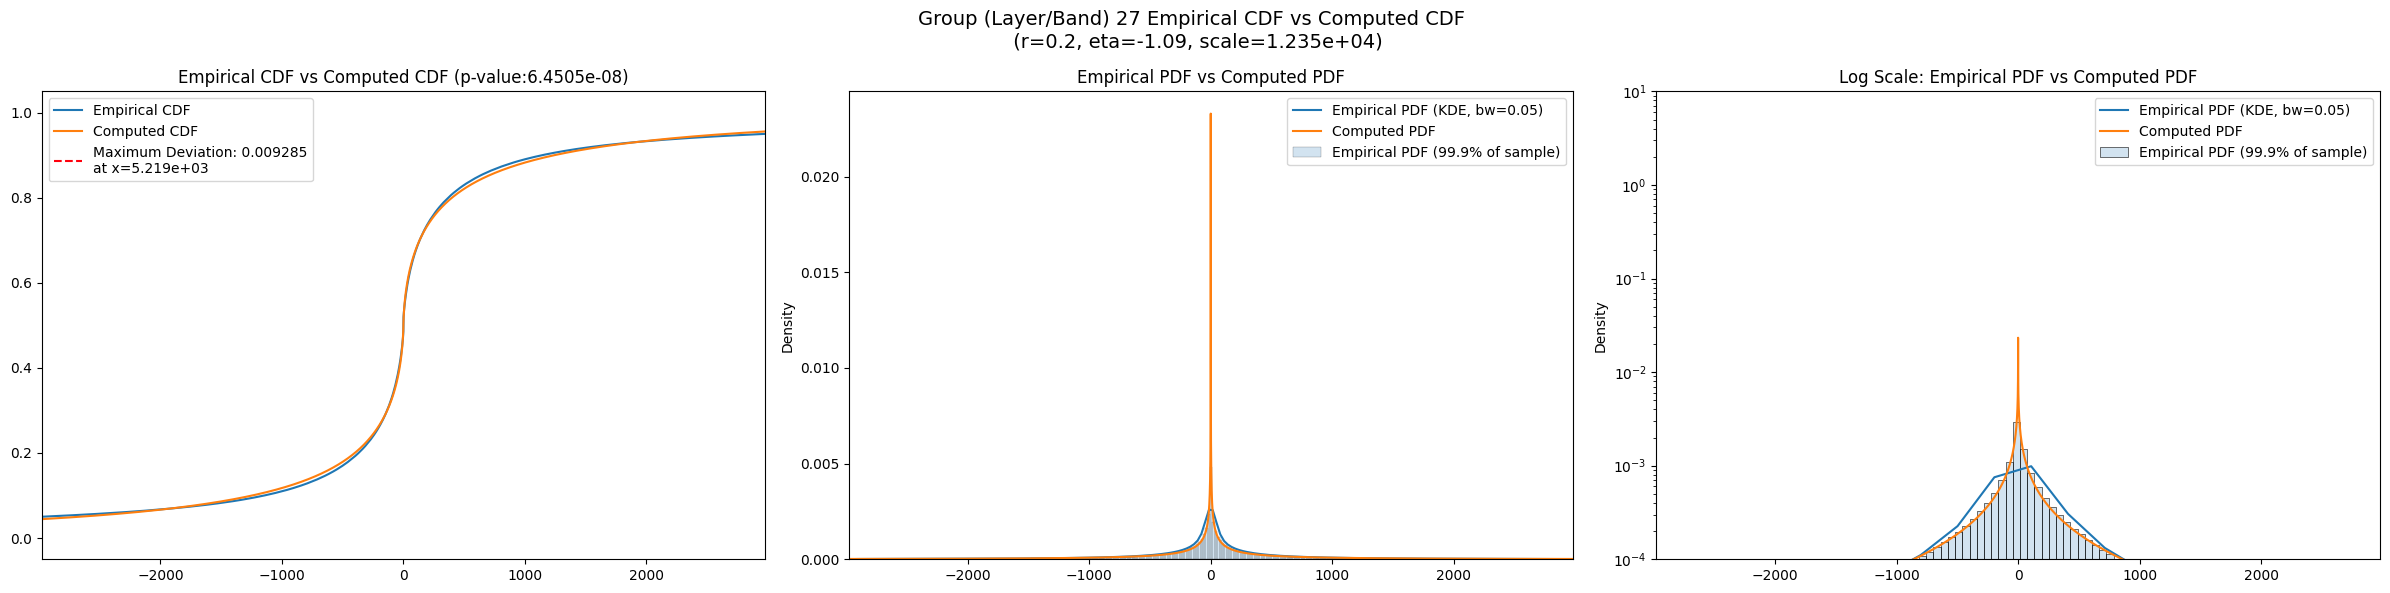

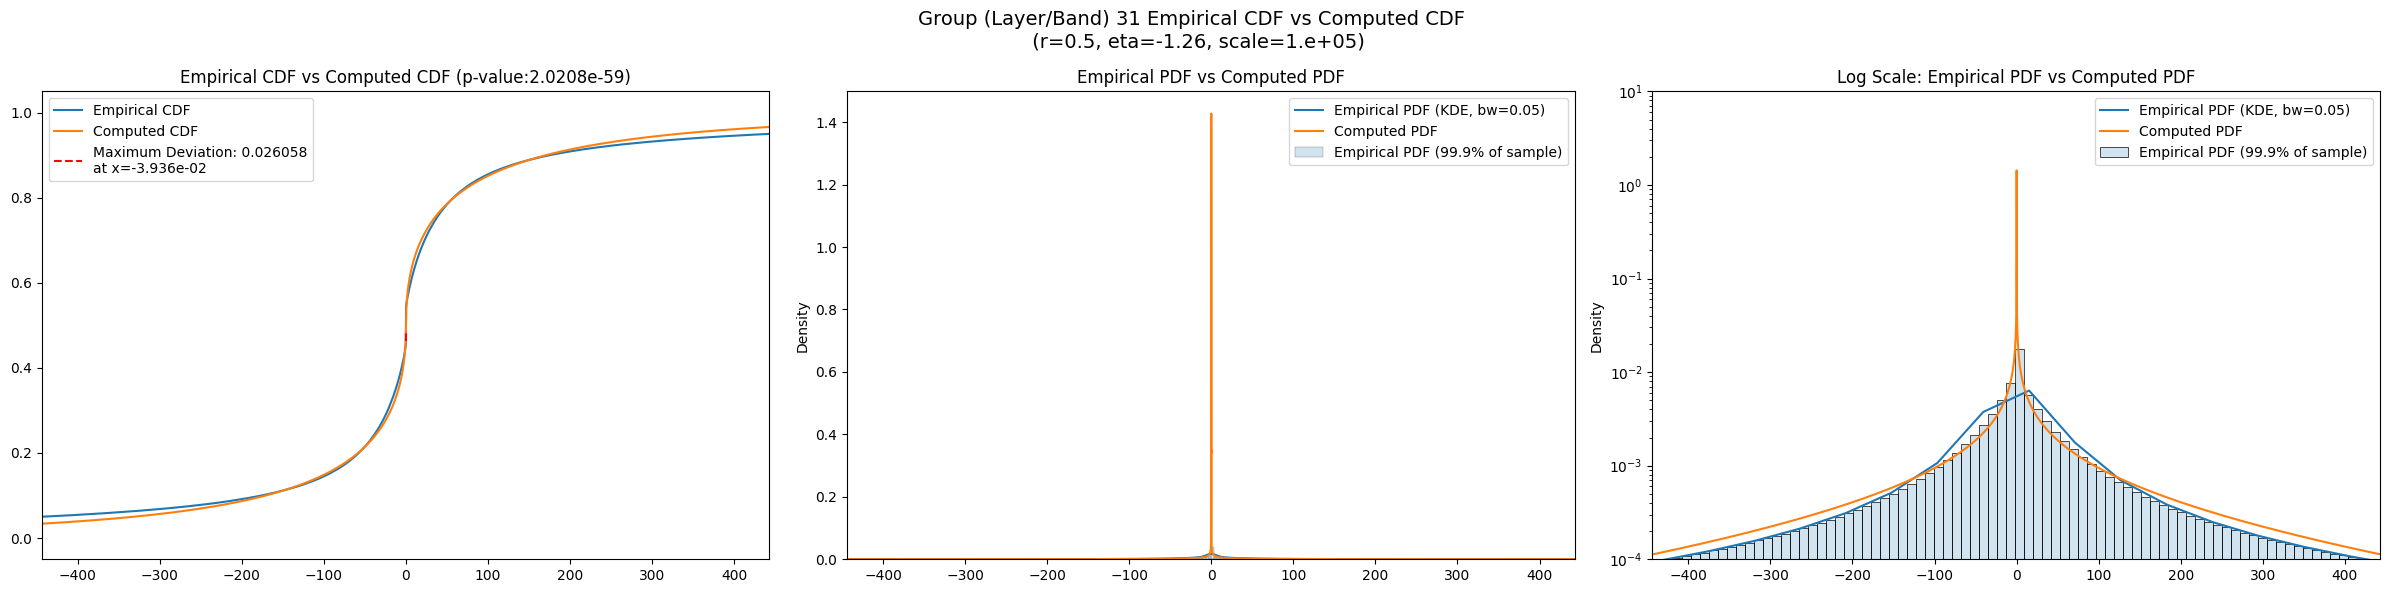

In [22]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [23]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [24]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304364e+08  8.450577e+08  1.021506e+09  11.473453    9.685472   
5     2.321099e+09  2.173827e+09  2.472827e+09   4.321749    3.780649   
8     1.711880e+09  1.608208e+09  1.819152e+09   3.817738    3.300339   
11    1.487492e+09  1.403327e+09  1.572967e+09   2.947570    2.643493   
14    3.505658e+08  3.214803e+08  3.808777e+08   8.853598    7.760434   
18    7.140621e+07  6.547071e+07  7.783148e+07   9.277631    7.097496   
21    2.798554e+07  2.521406e+07  3.104261e+07  14.152540   10.132266   
24    2.339963e+07  2.047373e+07  2.657507e+07  23.594416   19.813868   
27    1.142615e+07  9.846249e+06  1.313120e+07  29.143429   24.490961   
31    3.075916e+05  2.548352e+05  3.733561e+05  52.778656   33.753050   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.096589       100000.0             0.023594        0.1          0.0   
5       4.902878       100000.0             0.032372        0.2         -0.1   
8       4.358519       100000.0             0.024266        0.2          0.4   
11      3.266759       100000.0             0.030990        0.2          0.1   
14     10.020346       100000.0             0.017476        0.2         -0.5   
18     12.407567       100000.0             0.016338        0.2         -0.2   
21     20.440014       100000.0             0.015076        0.2         -0.4   
24     27.847523       100000.0             0.008123        0.2         -1.0   
27     34.455246       100000.0             0.010087        0.2         -1.1   
31    124.280266       100000.0             0.032925        0.2         -1.1   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...        8540.650              0.092293          0.000000e+00   
5     ...       26223.800              0.075329          0.000000e+00   
8     ...       26173.400              0.058105         6.504470e-294   
11    ...       22091.000              0.074382          0.000000e+00   
14    ...        7782.390              0.079161          0.000000e+00   
18    ...        4380.590              0.066614          0.000000e+00   
21    ...        2337.160              0.071266          0.000000e+00   
24    ...        1042.310              0.091069          0.000000e+00   
27    ...         482.045              0.092030          0.000000e+00   
31    ...          77.641              0.088624          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2          7611.150             0.068142         0.000000e+00   5762.6400   
5         22111.300             0.051532        3.094750e-231  17645.5000   
8         22356.200             0.033263         1.454160e-96  18175.0000   
11        18936.700             0.048560        2.283450e-205  15102.1000   
14         6731.700             0.053125        9.805710e-246   5262.0900   
18         3787.540             0.040345        7.129970e-142   2974.6800   
21         2015.860             0.045753        2.399660e-182   1571.7900   
24          907.306             0.067129         0.000000e+00    685.7710   
27          421.243             0.069158         0.000000e+00    313.6210   
31           67.946             0.066265         0.000000e+00     49.9319   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.064830   0.000000e+00          4.733349e-41  
5          0.055264  6.695570e-266          3.398892e-88  
8          0.038292  7.729190e-128          6.868503e-51  
11         0.051756  3.028710e-233          1.380370e-80  
14         0.0542

## Results

In [25]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [26]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.023594                 0.004293          0.021624   
5                0.032372                 0.004293          0.031783   
8                0.024266                 0.004293          0.024101   
11               0.030990                 0.004293          0.030374   
14               0.017476                 0.004293          0.017222   
18               0.016338                 0.004293          0.015324   
21               0.015076                 0.004293          0.011476   
24               0.008123                 0.004293          0.007257   
27               0.010087                 0.004293          0.009647   
31               0.032925                 0.004293          0.026060   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.092293             0.068142       0.064830  
5                 0.075329             0.051532       0.055264  
8                 0.058105             0.033263       0.038292  
11                0.074382             0.048560       0.051756  
14                0.079161             0.053125       0.054253  
18                0.066614             0.040345       0.042145  
21                0.071266             0.045753       0.047129  
24                0.091069             0.067129       0.065955  
27                0.092030             0.069158       0.067286  
31                0.088624             0.066265       0.064513

In [27]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           9.304364e+08          0.021624    0.13     -0.40       6.042356   
5           2.321099e+09          0.031783    0.20     -0.13   45637.747200   
8           1.711880e+09          0.024101    0.21      0.30   24969.364078   
11          1.472723e+09          0.030374    0.21      0.00   43855.586842   
14          3.505658e+08          0.017222    0.20     -0.52   24995.119397   
18          7.140621e+07          0.015324    0.25     -0.50   85007.390476   
21          2.798554e+07          0.011476    0.26     -0.70   96455.702648   
24          2.339963e+07          0.007257    0.20     -0.98   14704.264636   
27          9.557462e+06          0.009647    0.20     -1.09   12353.417055   
31          1.461710e+05          0.026060    0.50     -1.26  100000.000000   

      best_exclude_cutoff  
band                       
2                     0.0  
5                     0.0  
8                     0.0  
11                   25.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                    0.0  
27                  100.0  
31                  450.0